In [1]:
%pip install tensorflow numpy matplotlib

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.0 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [10]:
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.datasets import mnist
import numpy as np

In [11]:
# Set random seed for reproducibility
tf.random.set_seed(42)

# Hyperparameters
batch_size = 128
epochs = 20
learning_rate = 0.001
sparse_lambda = 1e-3  # Sparsity penalty
contractive_lambda = 1e-4  # Contractive penalty
rho = 0.05  # Target sparsity
epsilon = 1e-6

(x_train, _), (x_test, _) = tf.keras.datasets.mnist.load_data()
x_train = x_train.astype('float32') / 255.0
x_test = x_test.astype('float32') / 255.0
x_train = np.expand_dims(x_train, axis=-1)  # Shape: (60000, 28, 28, 1)
x_test = np.expand_dims(x_test, axis=-1)  # Shape: (10000, 28, 28, 1)
train_dataset = tf.data.Dataset.from_tensor_slices(x_train).cache().shuffle(60000).batch(batch_size).prefetch(tf.data.AUTOTUNE)
test_dataset = tf.data.Dataset.from_tensor_slices(x_test).batch(batch_size).prefetch(tf.data.AUTOTUNE)

In [12]:
# U-Net-like Encoder
def build_encoder():
    inputs = layers.Input(shape=(28, 28, 1))
    x = layers.Conv2D(64, 3, padding='same', activation='relu')(inputs)  # 28x28x64
    x = layers.MaxPooling2D(2)(x)  # 14x14x64
    x = layers.Conv2D(128, 3, padding='same', activation='relu')(x)  # 14x14x128
    x = layers.MaxPooling2D(2)(x)  # 7x7x128
    x = layers.Conv2D(256, 3, padding='same', activation='relu')(x)  # 7x7x256
    x = layers.MaxPooling2D(2)(x)  # 3x3x256
    x = layers.Flatten()(x)
    z = layers.Dense(128)(x)  # Latent space
    return models.Model(inputs, z, name='encoder')


In [13]:
# U-Net-like Decoder
def build_decoder():
    inputs = layers.Input(shape=(128,))
    x = layers.Dense(256 * 3 * 3, activation='relu')(inputs)
    x = layers.Reshape((3, 3, 256))(x)
    x = layers.Conv2DTranspose(128, 3, strides=2, padding='same', activation='relu')(x)  # 6x6x128
    x = layers.Conv2DTranspose(64, 3, strides=2, padding='same', activation='relu')(x)  # 12x12x64
    x = layers.Conv2DTranspose(1, 3, strides=2, padding='same', activation='sigmoid')(x)  # 28x28x1
    x = layers.Conv2D(1, 3, padding='valid', activation='sigmoid')(x)  # 22x22x1
    x = layers.ZeroPadding2D(padding=((3, 3), (3, 3)))(x)  # 28x28x1
    return models.Model(inputs, x, name='decoder')

In [14]:
# Sparse Autoencoder
class SparseAutoencoder(models.Model):
    def __init__(self):
        super(SparseAutoencoder, self).__init__()
        self.encoder = build_encoder()
        self.decoder = build_decoder()

    def call(self, inputs):
        z = self.encoder(inputs)
        recon = self.decoder(z)
        return recon, z

In [15]:
# Contractive Autoencoder
class ContractiveAutoencoder(models.Model):
    def __init__(self):
        super(ContractiveAutoencoder, self).__init__()
        self.encoder = build_encoder()
        self.decoder = build_decoder()

    def call(self, inputs):
        z = self.encoder(inputs)
        recon = self.decoder(z)
        return recon, z

In [16]:
def sparse_ae_loss(y_true, y_pred, z):
    mse_loss = tf.reduce_mean(tf.keras.losses.mse(y_true, y_pred))
    rho_hat = tf.reduce_mean(z, axis=0)
    # Clip rho_hat to avoid log(0) or division by zero
    rho_hat = tf.clip_by_value(rho_hat, epsilon, 1 - epsilon)
    kl_div = rho * tf.math.log(rho / rho_hat) + (1 - rho) * tf.math.log((1 - rho) / (1 - rho_hat))
    kl_loss = sparse_lambda * tf.reduce_sum(tf.clip_by_value(kl_div, -1e4, 1e4))  # Clip KL term
    return mse_loss + kl_loss

# Contractive Autoencoder Loss
def contractive_ae_loss(x, recon, z, model):
    mse_loss = tf.reduce_mean(tf.square(x - recon))
    with tf.GradientTape() as tape:
        tape.watch(z)
        recon = model.decoder(z)
    grad_z = tape.gradient(recon, z)
    j_loss = contractive_lambda * tf.reduce_mean(tf.reduce_sum(tf.square(grad_z), axis=1))
    return mse_loss + j_loss

In [17]:
# Training function
def train(model, dataset, loss_fn, epochs, model_type='sparse'):
    optimizer = tf.keras.optimizers.Adam(learning_rate)
    for epoch in range(epochs):
        total_loss = 0
        for batch in dataset:
            with tf.GradientTape() as tape:
                recon, z = model(batch)
                if model_type == 'sparse':
                    loss = loss_fn(batch, recon, z)
                else:
                    loss = loss_fn(batch, recon, z, model)
            gradients = tape.gradient(loss, model.trainable_variables)
            optimizer.apply_gradients(zip(gradients, model.trainable_variables))
            total_loss += loss.numpy()
        print(f'Epoch {epoch+1}/{epochs}, {model_type.capitalize()} AE Loss: {total_loss / len(dataset):.6f}')

In [18]:
# Initialize and compile models
sparse_ae = SparseAutoencoder()
contractive_ae = ContractiveAutoencoder()

# Print model summary
print("Sparse Autoencoder Summary:")
sparse_ae.summary()

print("\nContractive Autoencoder Summary:")
contractive_ae.summary()

# Train Sparse Autoencoder
print("Training Sparse Autoencoder...")
train(sparse_ae, train_dataset, sparse_ae_loss, epochs, model_type='sparse')

# Train Contractive Autoencoder
print("\nTraining Contractive Autoencoder...")
train(contractive_ae, train_dataset, contractive_ae_loss, epochs, model_type='contractive')

Sparse Autoencoder Summary:


Model: "sparse_autoencoder_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ encoder (Functional)            │ (None, 128)            │       664,704 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ decoder (Functional)            │ (None, 28, 28, 1)      │       666,635 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,331,339 (5.08 MB)

 Trainable params: 1,331,339 (5.08 MB)

 Non-trainable params: 0 (0.00 B)


Contractive Autoencoder Summary:


Model: "contractive_autoencoder_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ encoder (Functional)            │ (None, 128)            │       664,704 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ decoder (Functional)            │ (None, 28, 28, 1)      │       666,635 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,331,339 (5.08 MB)

 Trainable params: 1,331,339 (5.08 MB)

 Non-trainable params: 0 (0.00 B)

Training Sparse Autoencoder...
Epoch 1/20, Sparse AE Loss: 0.085450
Epoch 2/20, Sparse AE Loss: 0.043105
Epoch 3/20, Sparse AE Loss: 0.030969
Epoch 4/20, Sparse AE Loss: 0.024265
Epoch 5/20, Sparse AE Loss: 0.019756
Epoch 6/20, Sparse AE Loss: 0.016566
Epoch 7/20, Sparse AE Loss: 0.012820
Epoch 8/20, Sparse AE Loss: 0.011740
Epoch 9/20, Sparse AE Loss: 0.010668
Epoch 10/20, Sparse AE Loss: 0.009029
Epoch 11/20, Sparse AE Loss: 0.008051
Epoch 12/20, Sparse AE Loss: 0.007326
Epoch 13/20, Sparse AE Loss: 0.007077
Epoch 14/20, Sparse AE Loss: 0.005982
Epoch 15/20, Sparse AE Loss: 0.005221
Epoch 16/20, Sparse AE Loss: 0.005098
Epoch 17/20, Sparse AE Loss: 0.004991
Epoch 18/20, Sparse AE Loss: 0.004886
Epoch 19/20, Sparse AE Loss: 0.004815
Epoch 20/20, Sparse AE Loss: 0.004604

Training Contractive Autoencoder...
Epoch 1/20, Contractive AE Loss: 0.065558
Epoch 2/20, Contractive AE Loss: 0.028034
Epoch 3/20, Contractive AE Loss: 0.017730
Epoch 4/20, Contractive AE Loss: 0.012788
Epoch 5/20, C


Reconstructing and Validating Sparse Autoencoder...
Sparse Autoencoder Test MSE: 0.003153


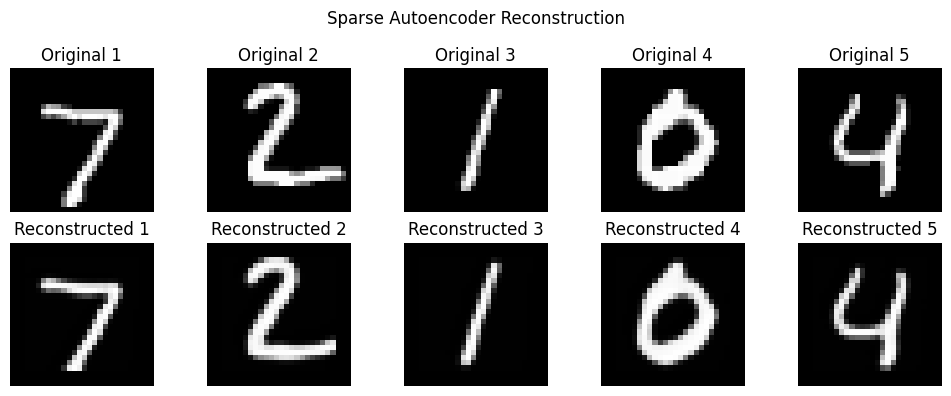


Reconstructing and Validating Contractive Autoencoder...
Contractive Autoencoder Test MSE: 0.003223


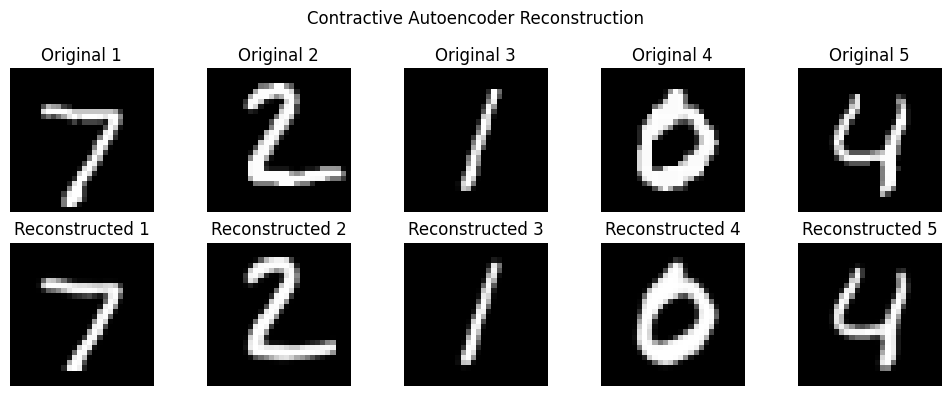

In [19]:

import matplotlib.pyplot as plt
# Load and preprocess MNIST dataset (modified to include test set)
(x_train, _), (x_test, _) = tf.keras.datasets.mnist.load_data()
x_train = x_train.astype('float32') / 255.0
x_test = x_test.astype('float32') / 255.0
x_train = np.expand_dims(x_train, axis=-1)  # Shape: (60000, 28, 28, 1)
x_test = np.expand_dims(x_test, axis=-1)  # Shape: (10000, 28, 28, 1)
train_dataset = tf.data.Dataset.from_tensor_slices(x_train).cache().shuffle(60000).batch(batch_size).prefetch(tf.data.AUTOTUNE)
test_dataset = tf.data.Dataset.from_tensor_slices(x_test).batch(batch_size).prefetch(tf.data.AUTOTUNE)

# Function to reconstruct and validate images
def reconstruct_and_validate(model, dataset, model_name, num_images=5):
    # Get one batch from the test dataset
    for batch in dataset.take(1):
        original_images = batch.numpy()
        recon_images, _ = model(batch, training=False)
        recon_images = recon_images.numpy()

    # Compute MSE for the batch
    mse = np.mean((original_images - recon_images) ** 2)
    print(f"{model_name} Test MSE: {mse:.6f}")

    # Visualize original and reconstructed images
    plt.figure(figsize=(10, 4))
    for i in range(num_images):
        # Original image
        plt.subplot(2, num_images, i + 1)
        plt.imshow(original_images[i].reshape(28, 28), cmap='gray')
        plt.title(f"Original {i+1}")
        plt.axis('off')
        # Reconstructed image
        plt.subplot(2, num_images, i + num_images + 1)
        plt.imshow(recon_images[i].reshape(28, 28), cmap='gray')
        plt.title(f"Reconstructed {i+1}")
        plt.axis('off')
    plt.suptitle(f"{model_name} Reconstruction")
    plt.tight_layout()
    plt.show()

# After training, reconstruct and validate
print("\nReconstructing and Validating Sparse Autoencoder...")
reconstruct_and_validate(sparse_ae, test_dataset, "Sparse Autoencoder")

print("\nReconstructing and Validating Contractive Autoencoder...")
reconstruct_and_validate(contractive_ae, test_dataset, "Contractive Autoencoder")


Plotting t-SNE for Sparse Autoencoder...


e:\AI\ai-ml-course\venv\Lib\site-packages\sklearn\manifold\_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


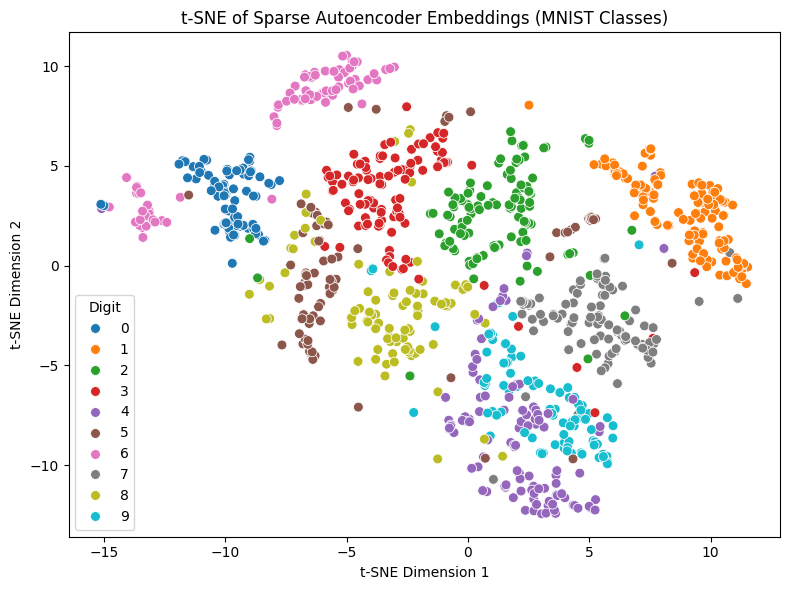


Plotting t-SNE for Contractive Autoencoder...


e:\AI\ai-ml-course\venv\Lib\site-packages\sklearn\manifold\_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


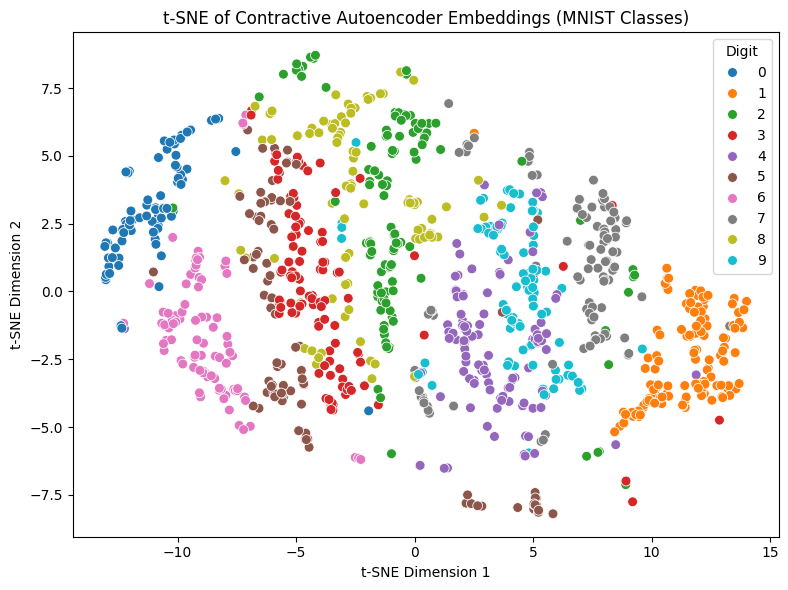

In [20]:
# Add required imports for t-SNE
from sklearn.manifold import TSNE
import seaborn as sns  # For better color palette

# Load and preprocess MNIST dataset (modified to include labels)
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()
x_train = x_train.astype('float32') / 255.0
x_test = x_test.astype('float32') / 255.0
x_train = np.expand_dims(x_train, axis=-1)  # Shape: (60000, 28, 28, 1)
x_test = np.expand_dims(x_test, axis=-1)   # Shape: (10000, 28, 28, 1)
train_dataset = tf.data.Dataset.from_tensor_slices(x_train).cache().shuffle(60000).batch(batch_size).prefetch(tf.data.AUTOTUNE)
test_dataset = tf.data.Dataset.from_tensor_slices((x_test, y_test)).batch(batch_size).prefetch(tf.data.AUTOTUNE)

# Function to plot t-SNE of embeddings
def plot_tsne_embeddings(model, dataset, model_name, num_samples=1000):
    # Extract embeddings and labels from test set
    embeddings = []
    labels = []
    for batch_images, batch_labels in dataset.take(num_samples // batch_size + 1):
        z = model.encoder(batch_images, training=False).numpy()
        embeddings.append(z)
        labels.append(batch_labels.numpy())
    embeddings = np.concatenate(embeddings, axis=0)[:num_samples]
    labels = np.concatenate(labels, axis=0)[:num_samples]

    # Apply t-SNE to reduce to 2D
    tsne = TSNE(n_components=2, random_state=42, perplexity=30, n_iter=300)
    tsne_embeddings = tsne.fit_transform(embeddings)

    # Plot t-SNE with colors for each class
    plt.figure(figsize=(8, 6))
    sns.scatterplot(x=tsne_embeddings[:, 0], y=tsne_embeddings[:, 1], hue=labels, 
                    palette='tab10', legend='full', s=50)
    plt.title(f"t-SNE of {model_name} Embeddings (MNIST Classes)")
    plt.xlabel("t-SNE Dimension 1")
    plt.ylabel("t-SNE Dimension 2")
    plt.legend(title="Digit", loc="best")
    plt.tight_layout()
    plt.show()

# After training and validation, plot t-SNE
print("\nPlotting t-SNE for Sparse Autoencoder...")
plot_tsne_embeddings(sparse_ae, test_dataset, "Sparse Autoencoder")

print("\nPlotting t-SNE for Contractive Autoencoder...")
plot_tsne_embeddings(contractive_ae, test_dataset, "Contractive Autoencoder")


Interpolation Analysis for Sparse Autoencoder...


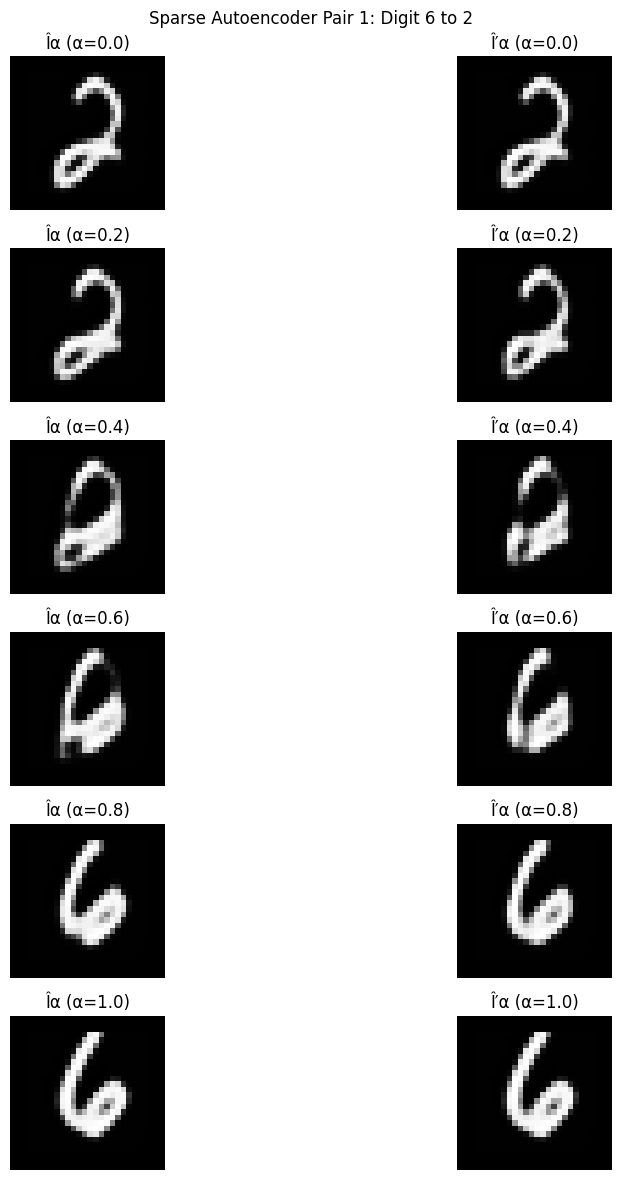

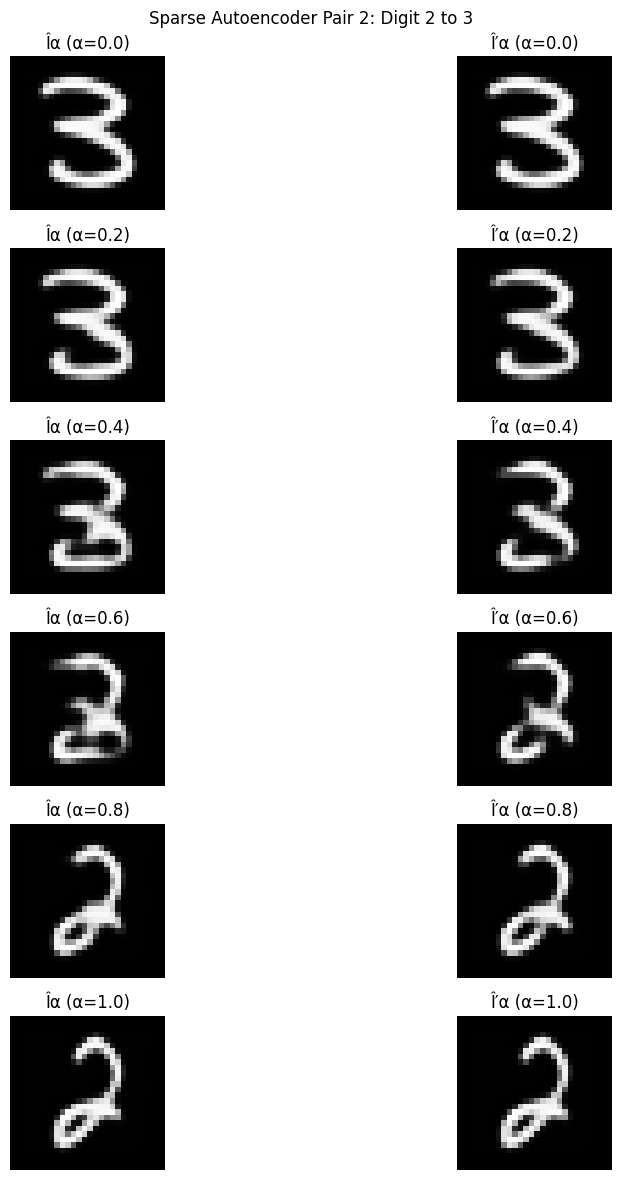

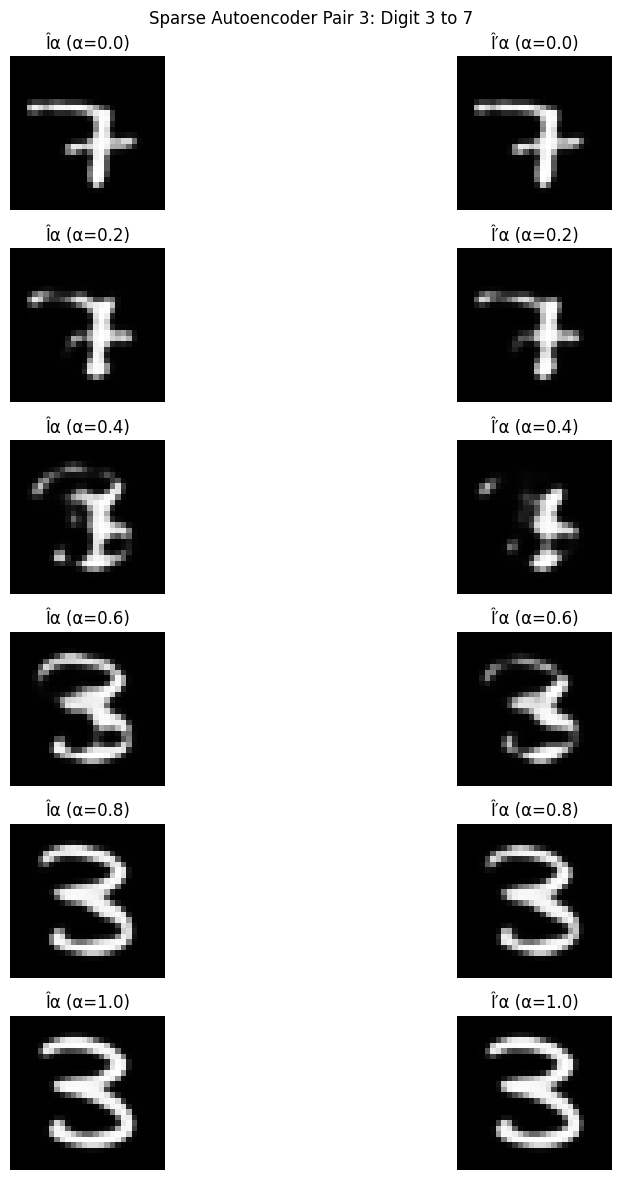

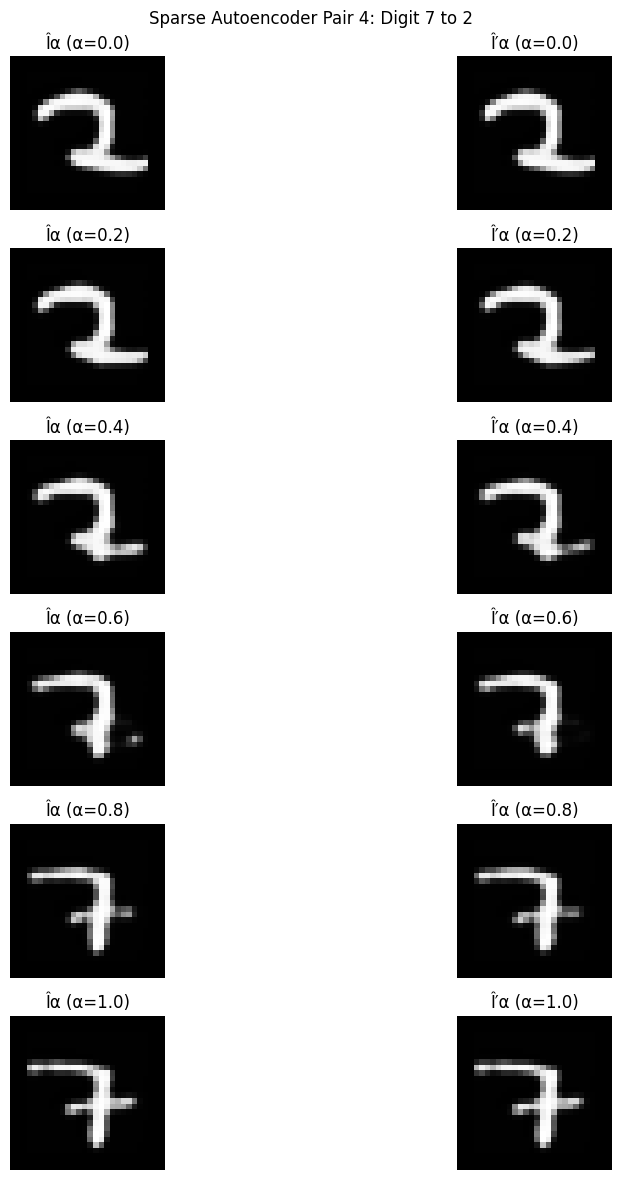

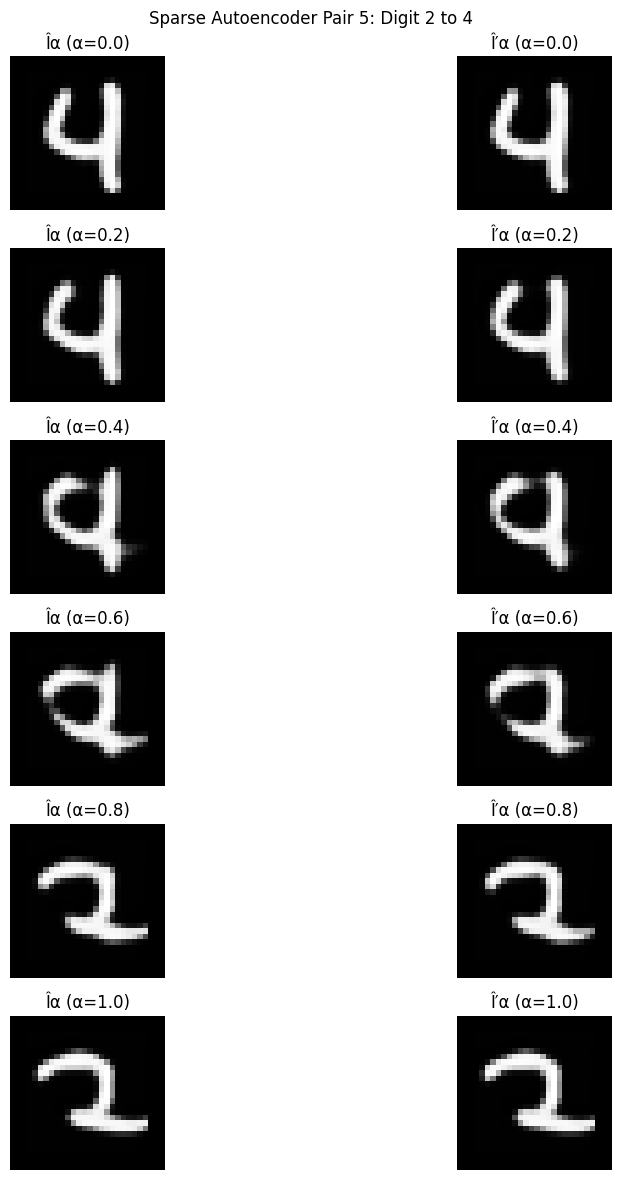

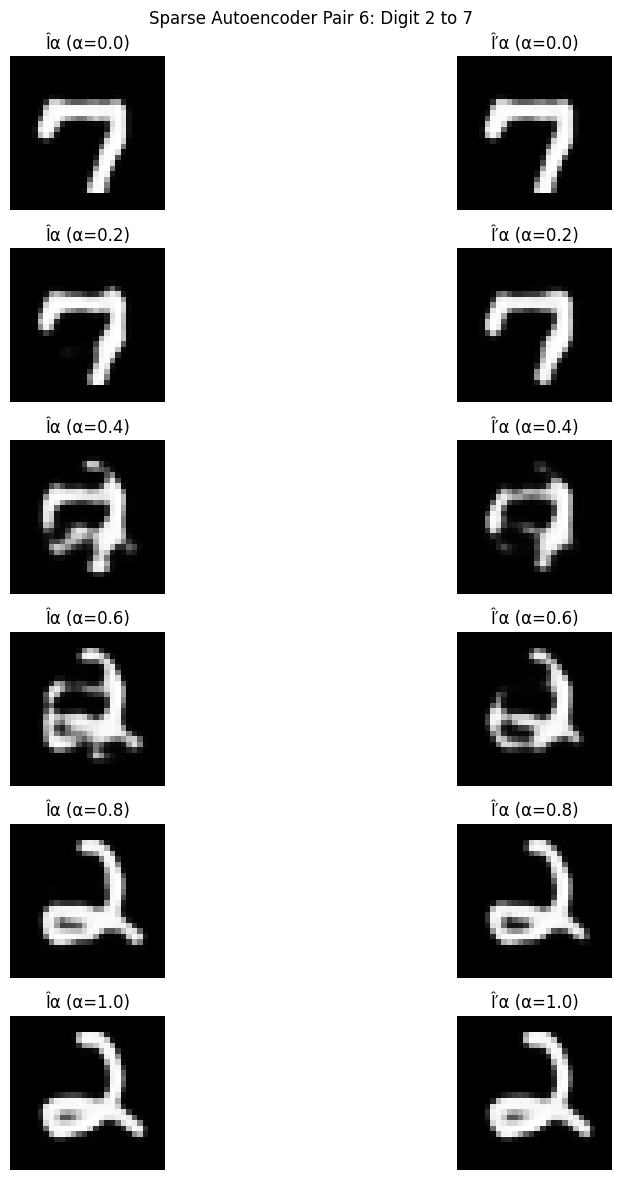

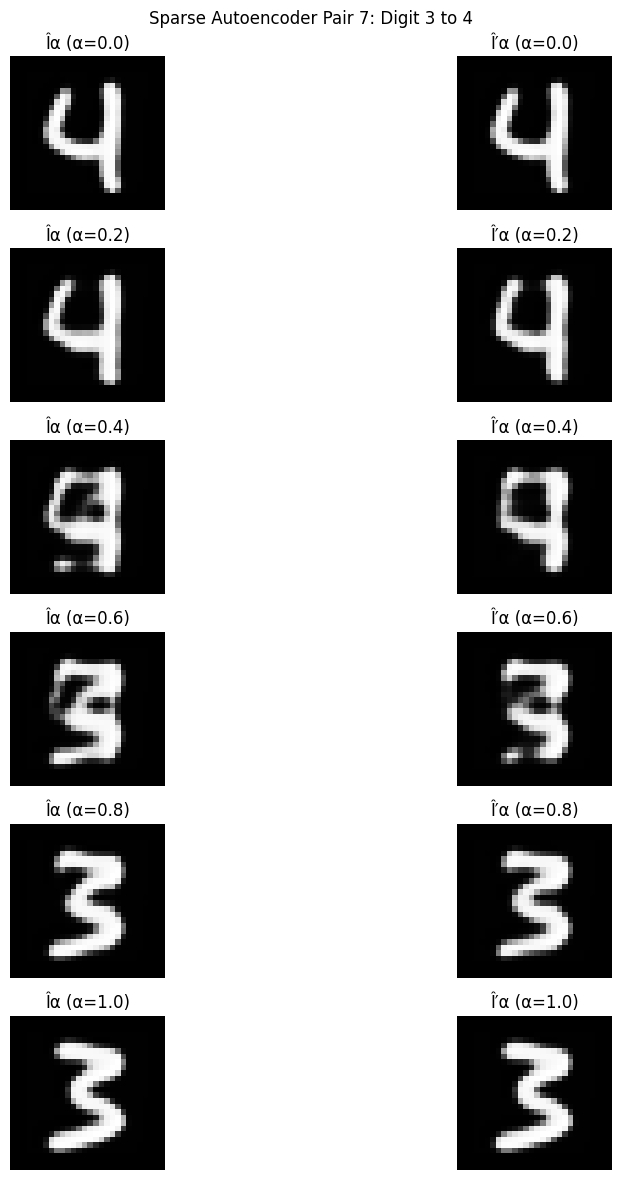

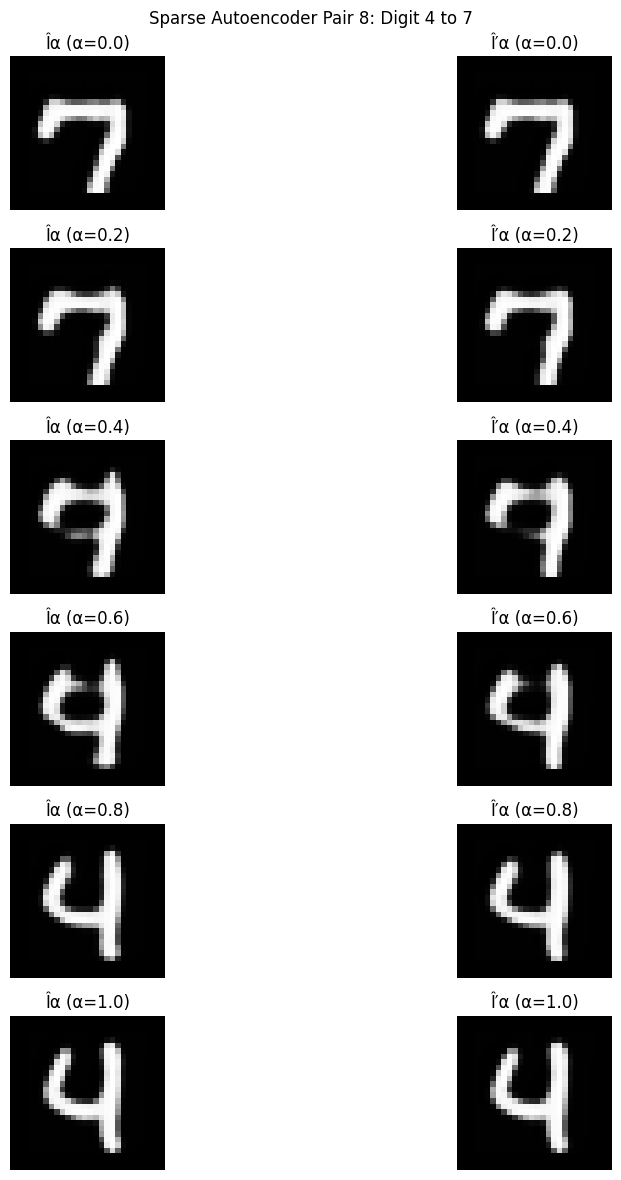

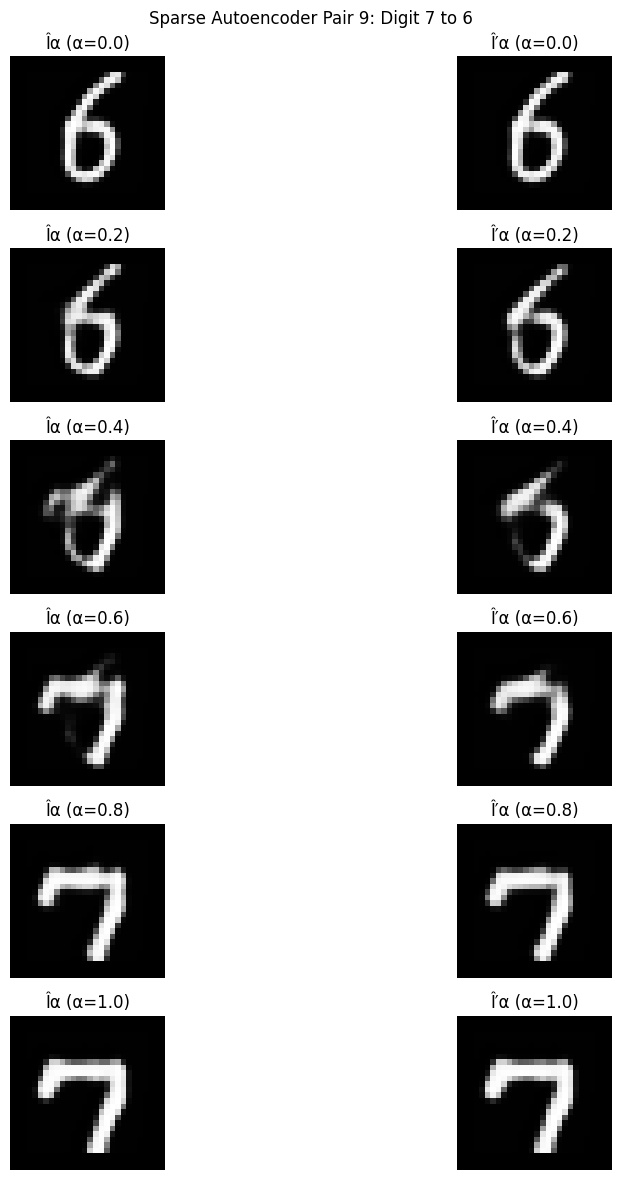

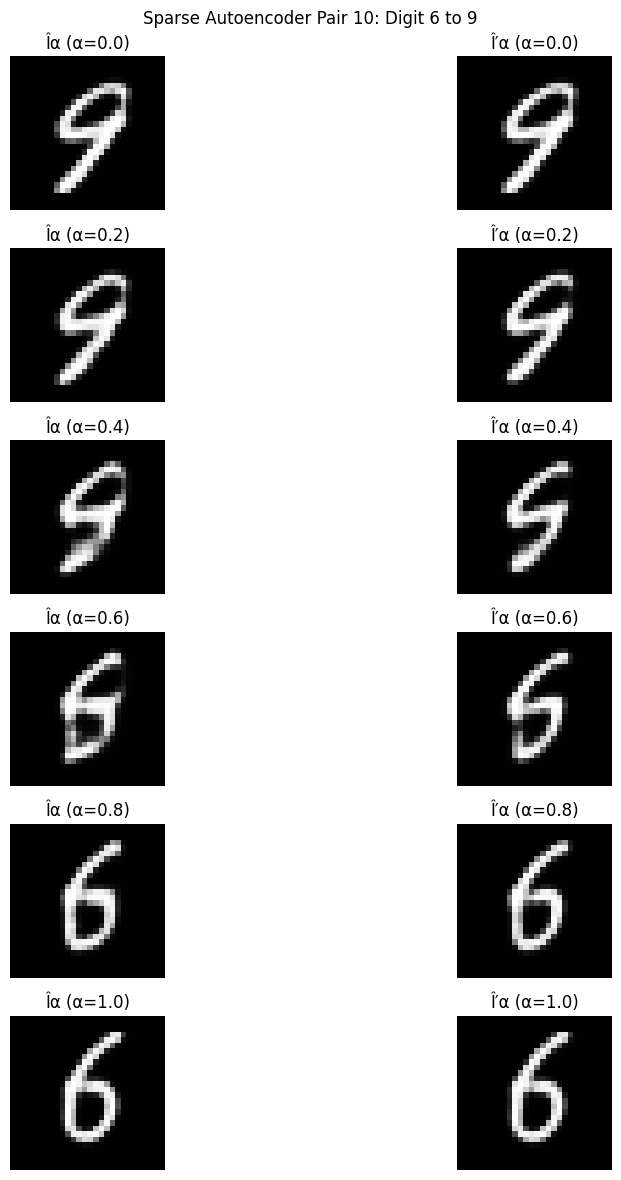

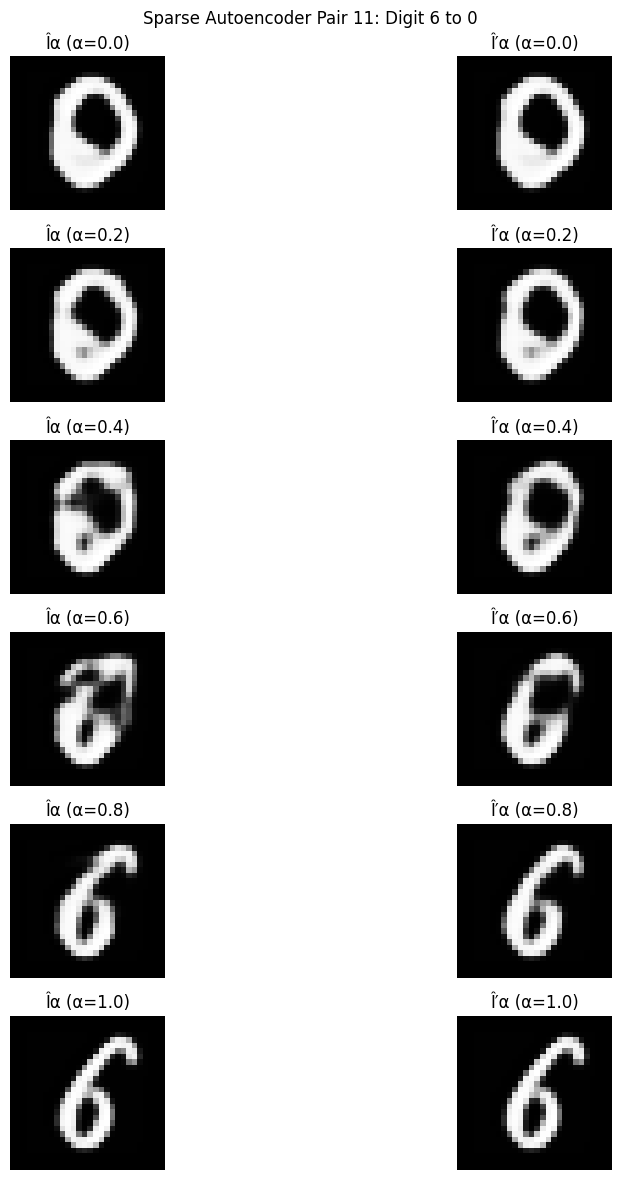

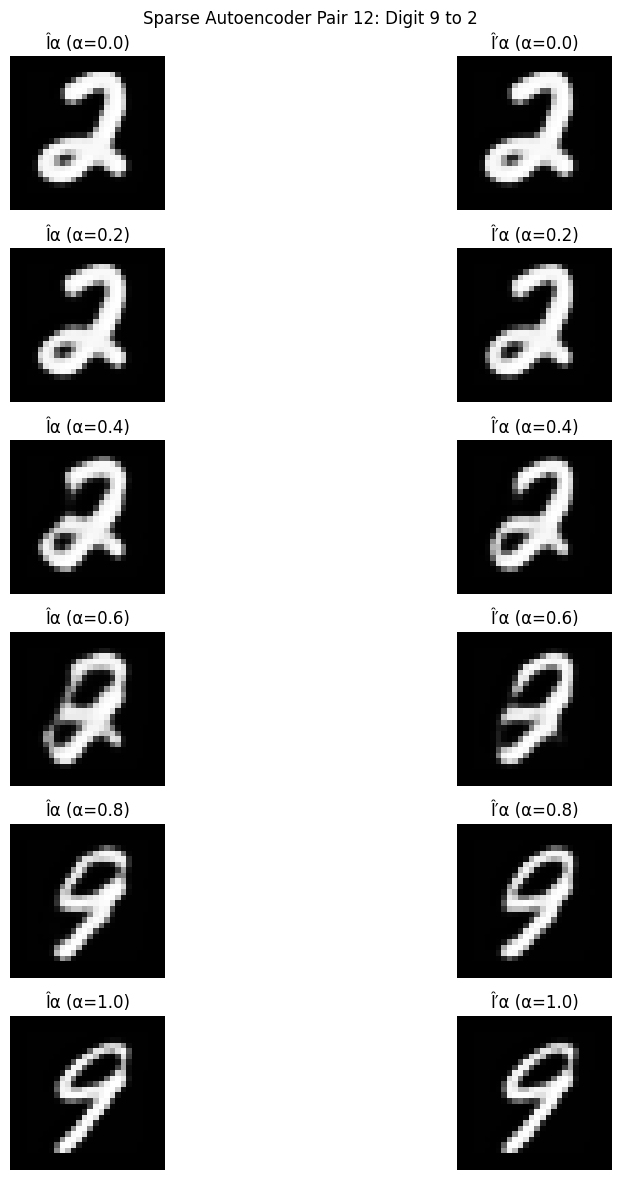

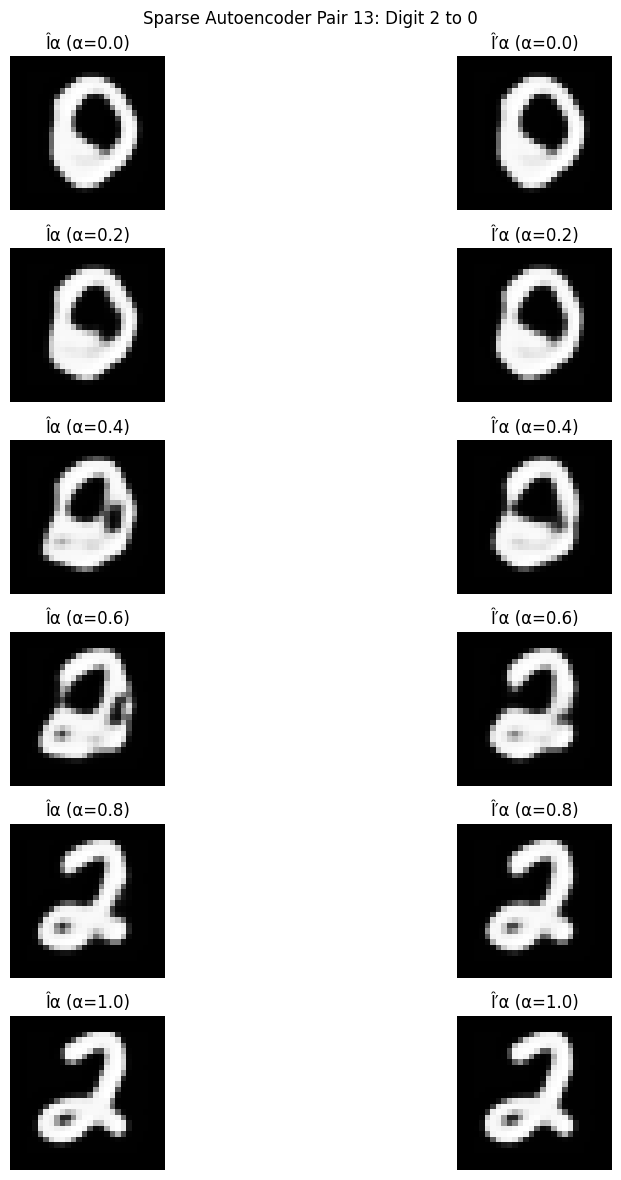

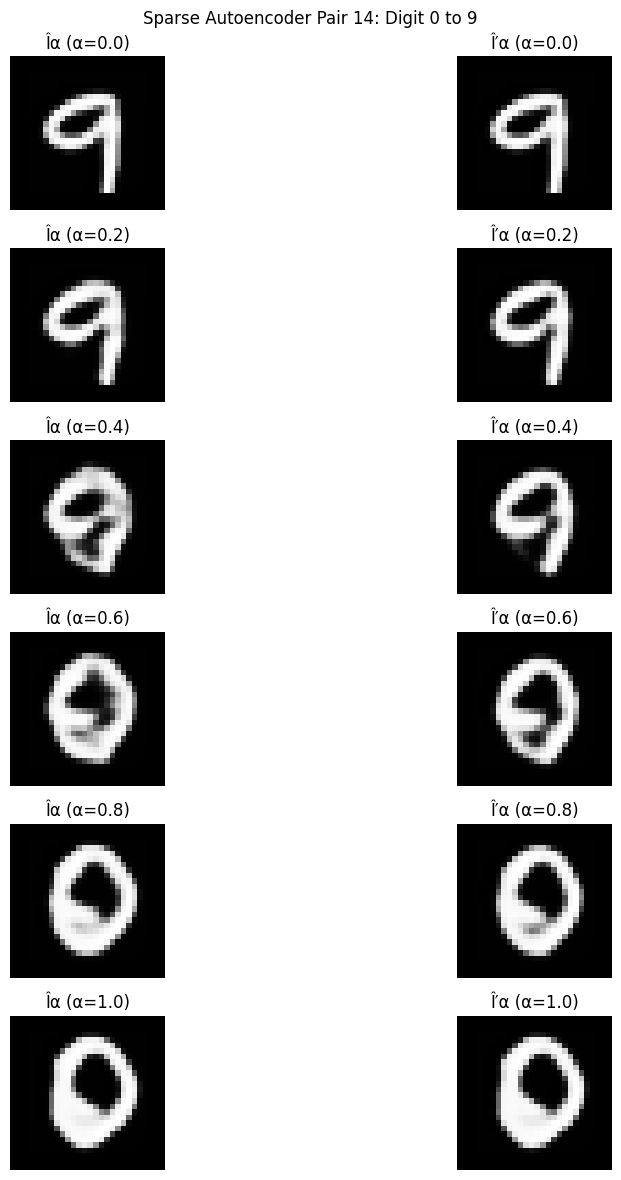

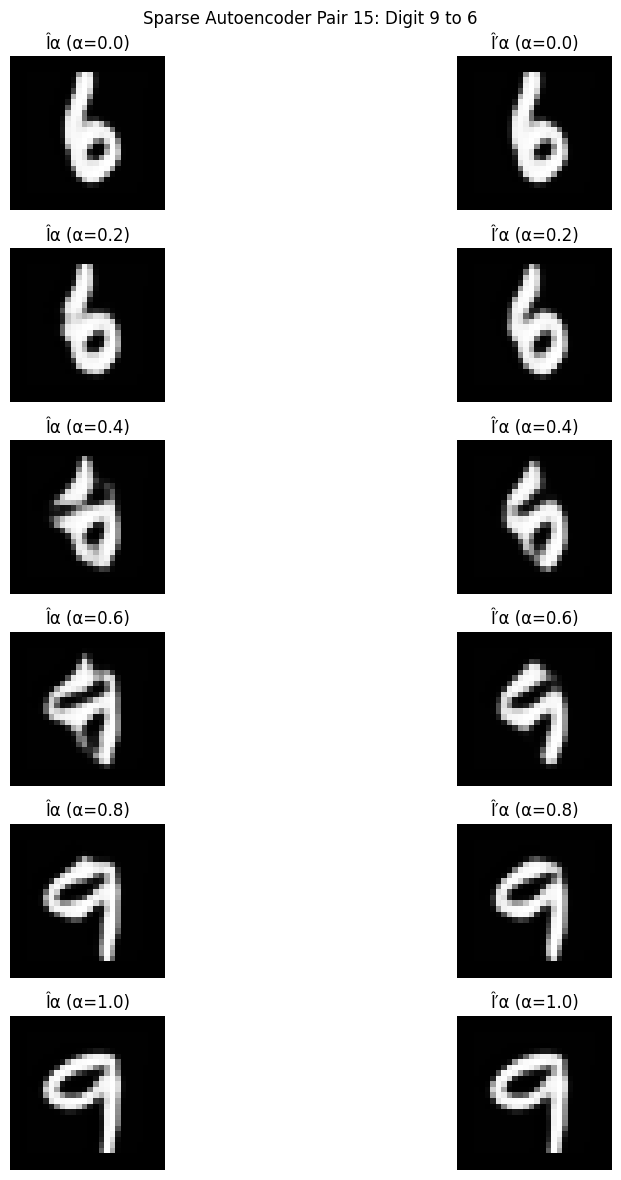

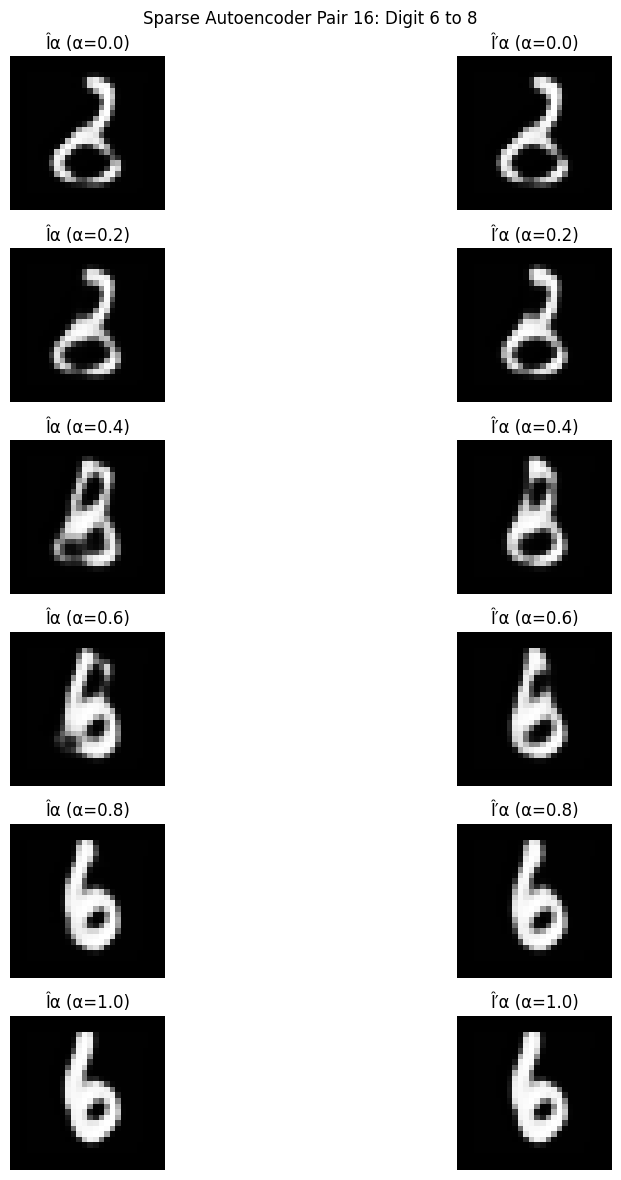

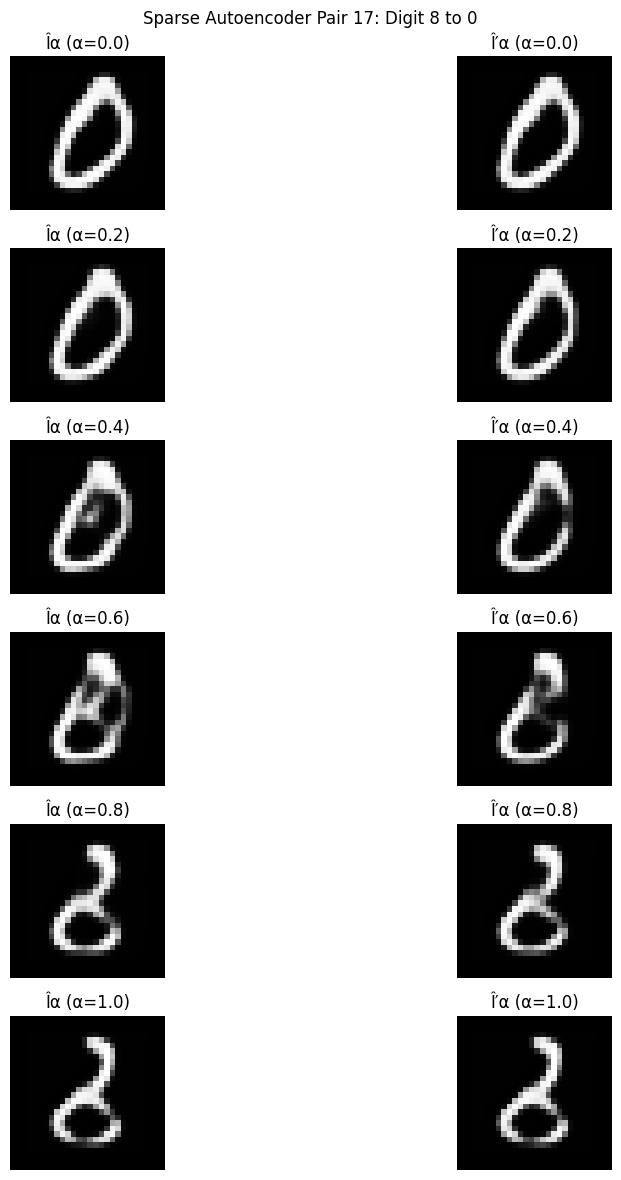

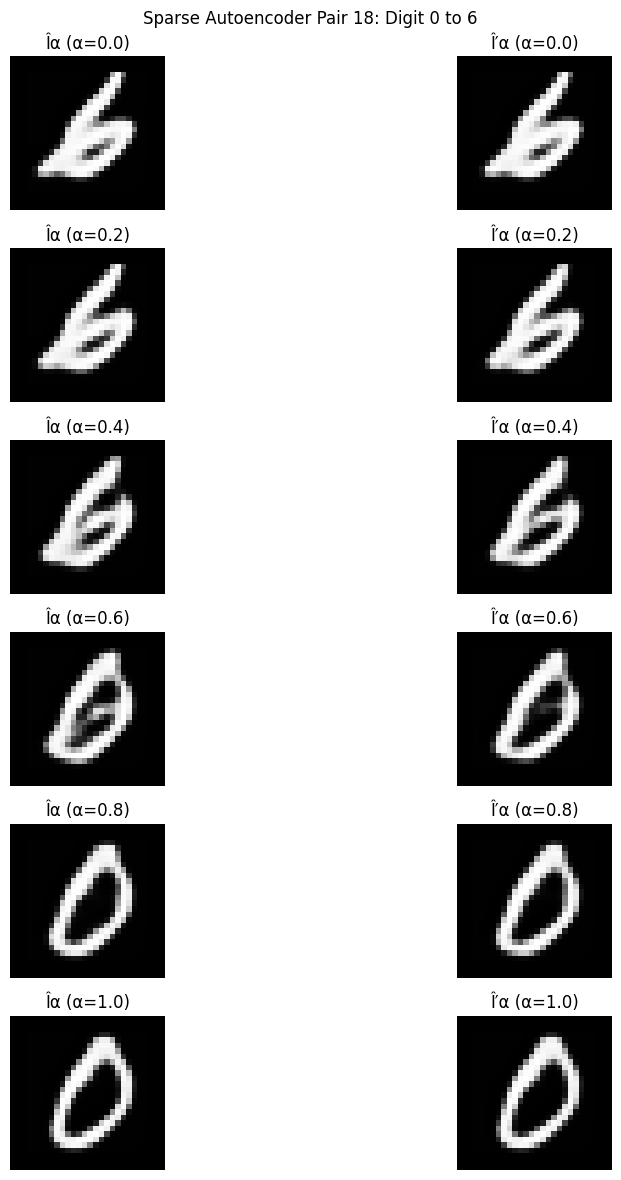

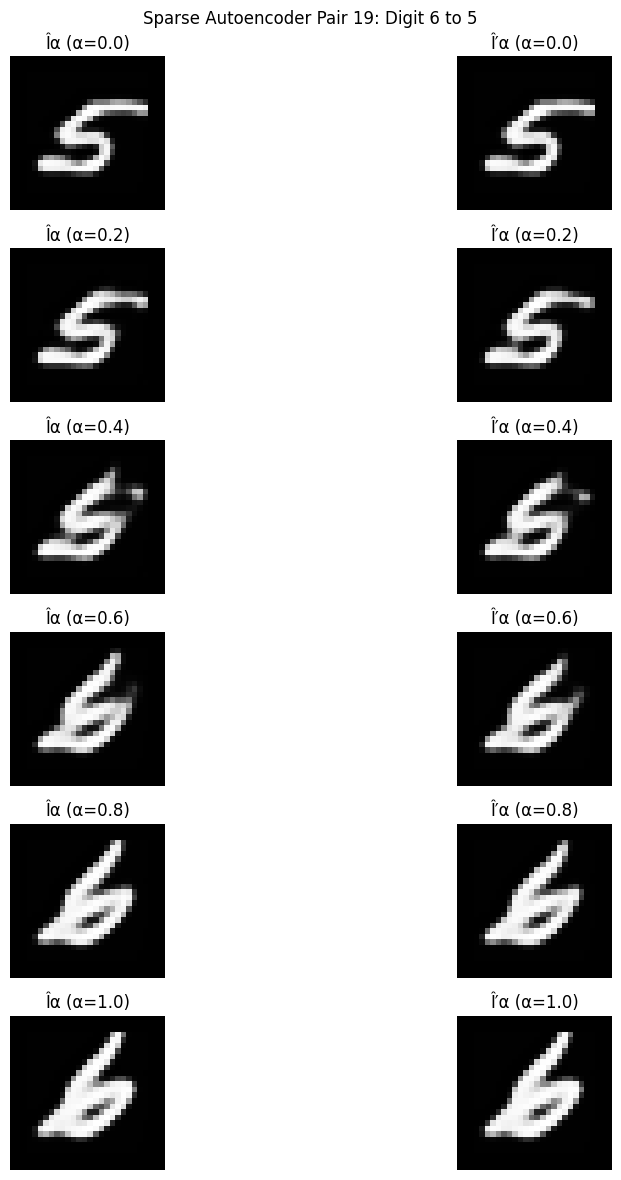

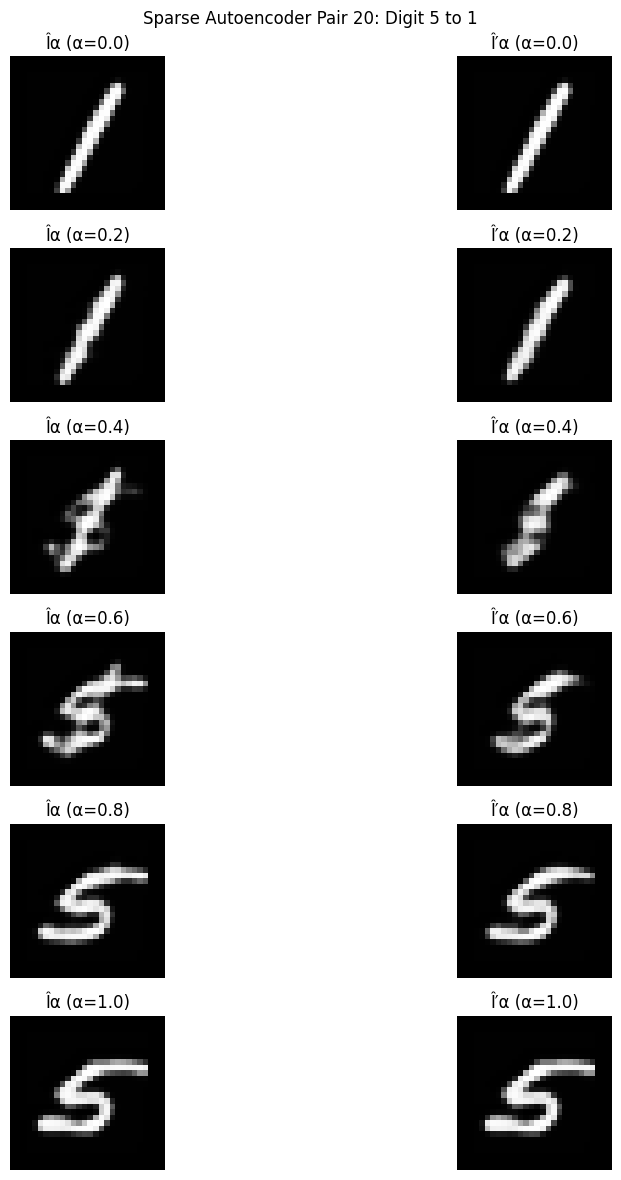


Sparse Autoencoder Metrics:
Alpha | Avg PSNR (dB) | Avg L2 Norm
------|---------------|------------
0.0  | inf      | 0.0000
0.2  | 26.3776      | 0.1477
0.4  | 20.5997      | 0.2284
0.6  | 20.4427      | 0.2305
0.8  | 26.9298      | 0.1512
1.0  | inf      | 0.0000

Interpolation Analysis for Contractive Autoencoder...


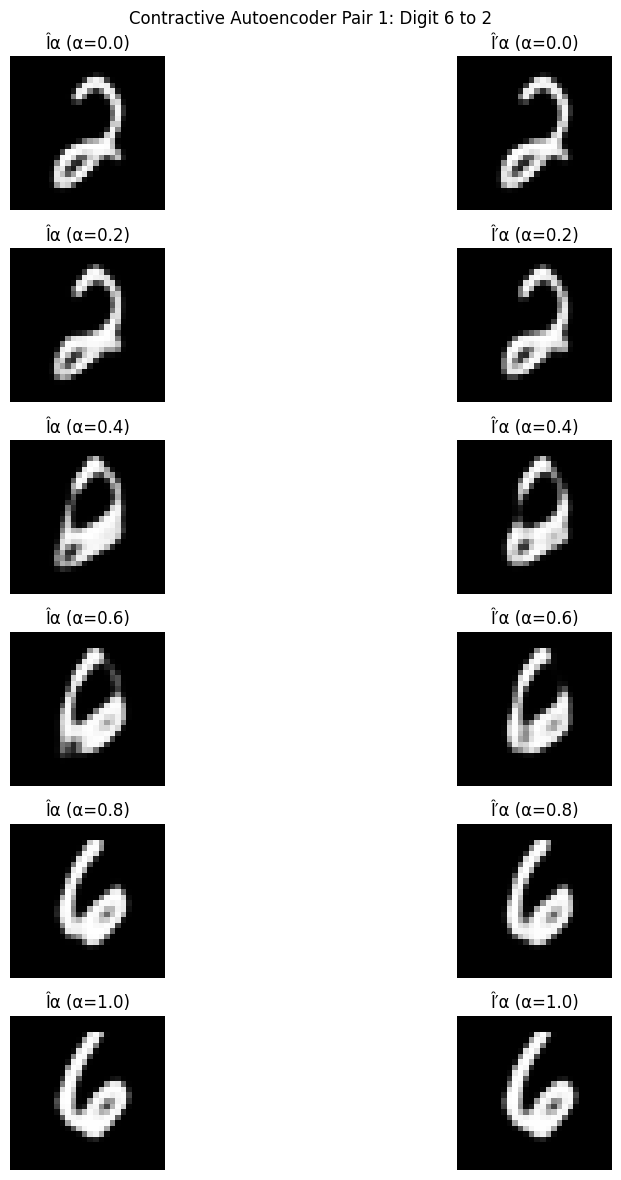

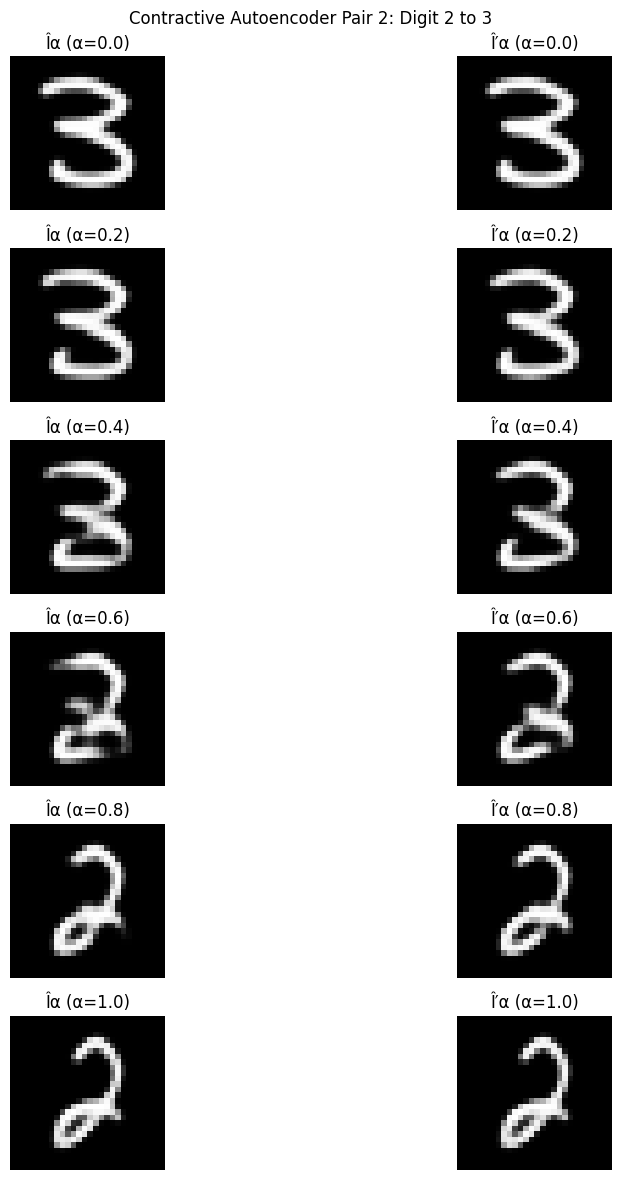

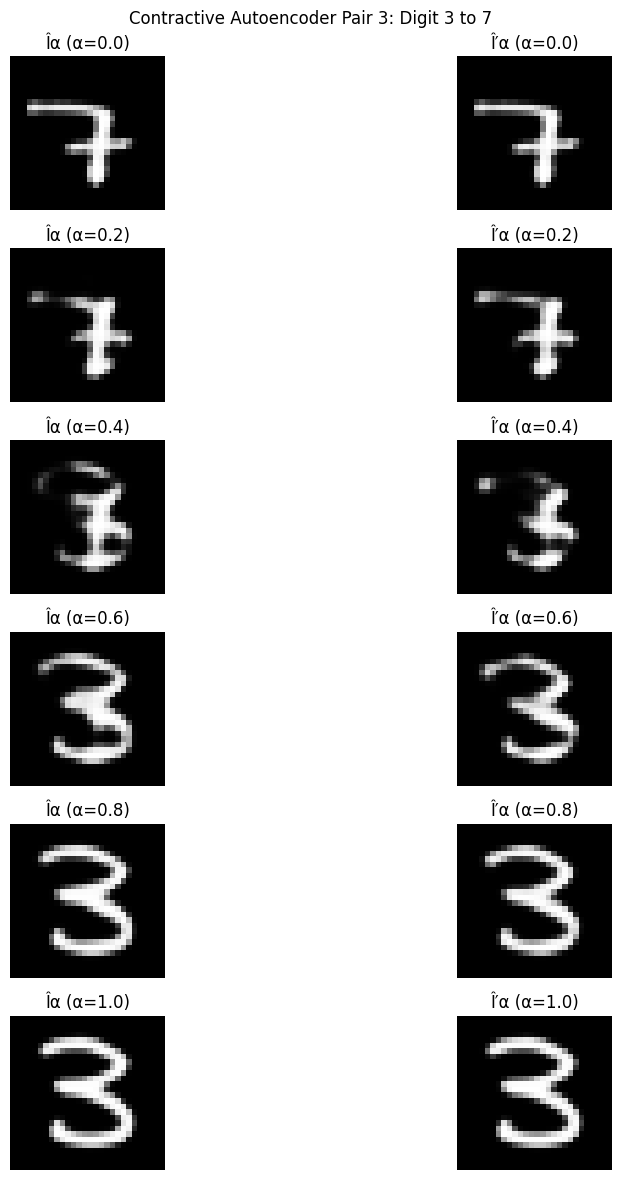

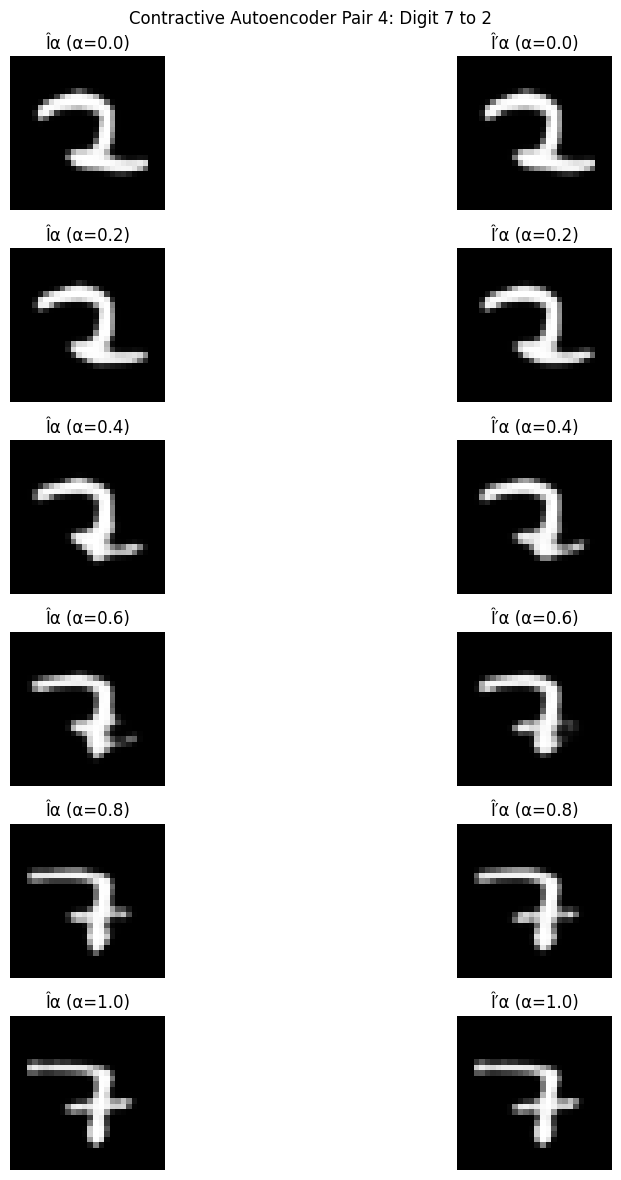

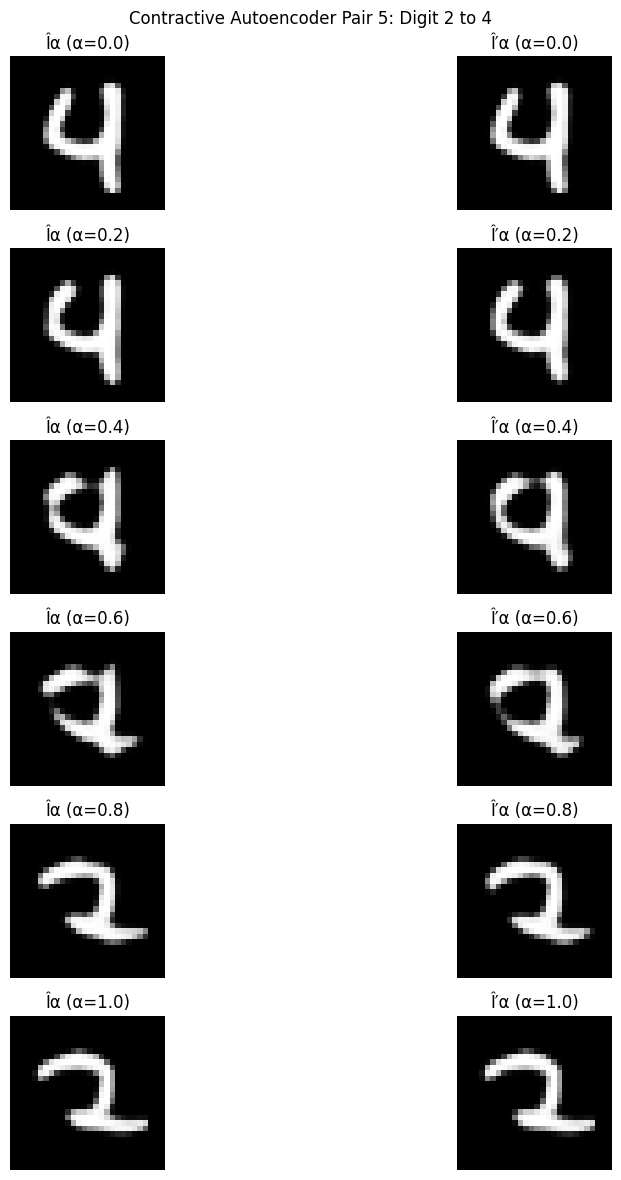

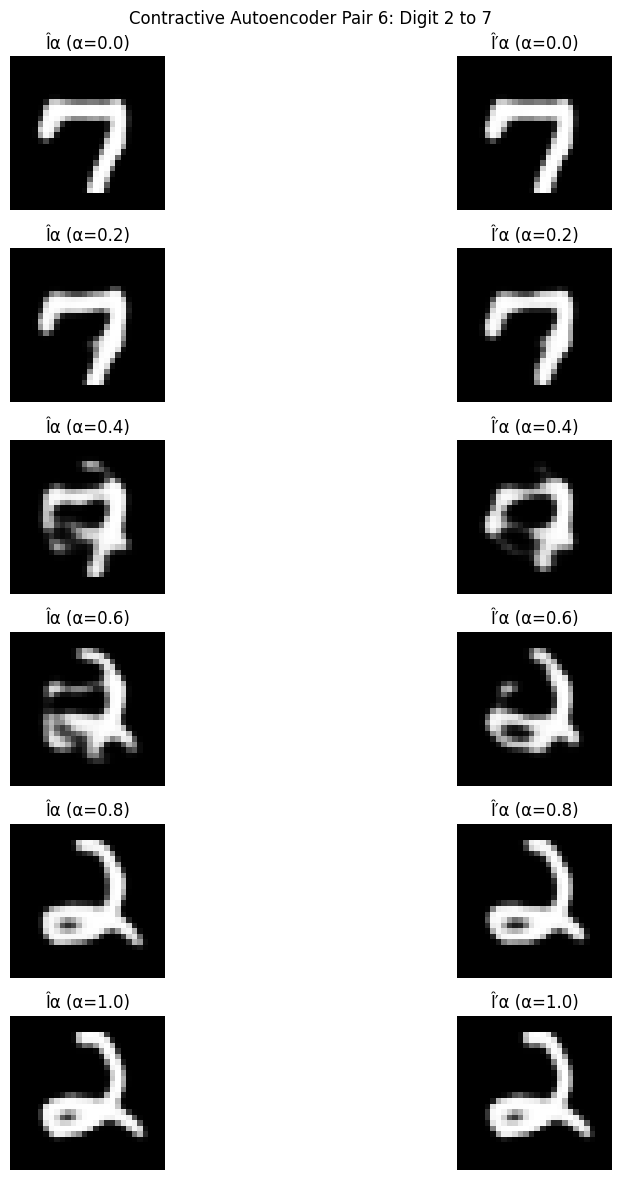

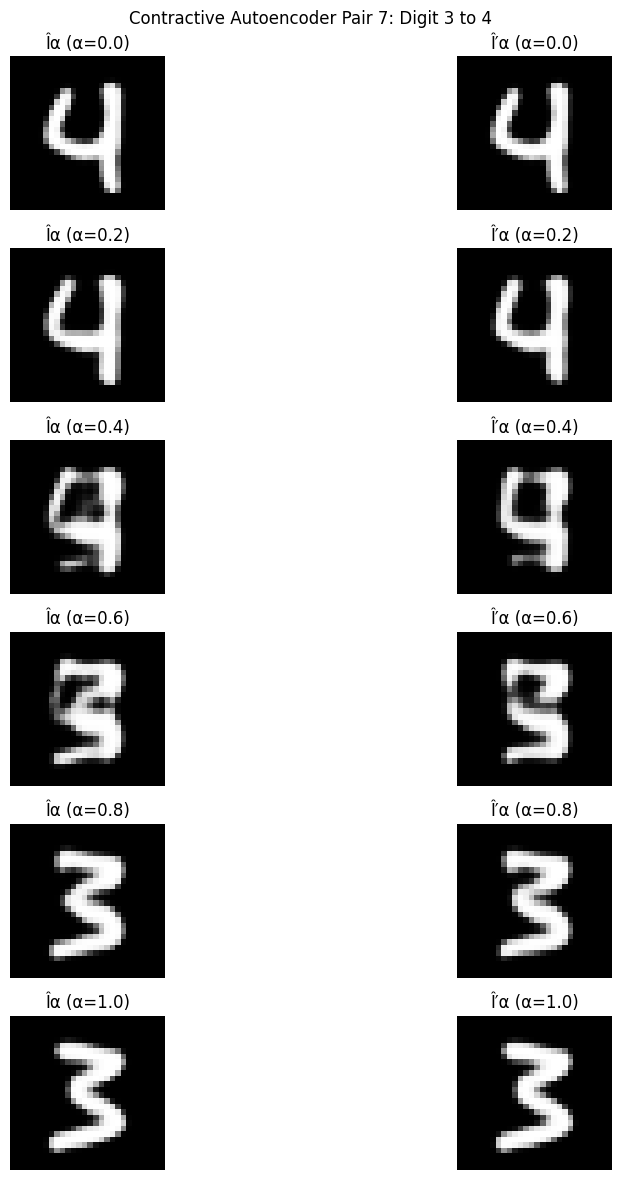

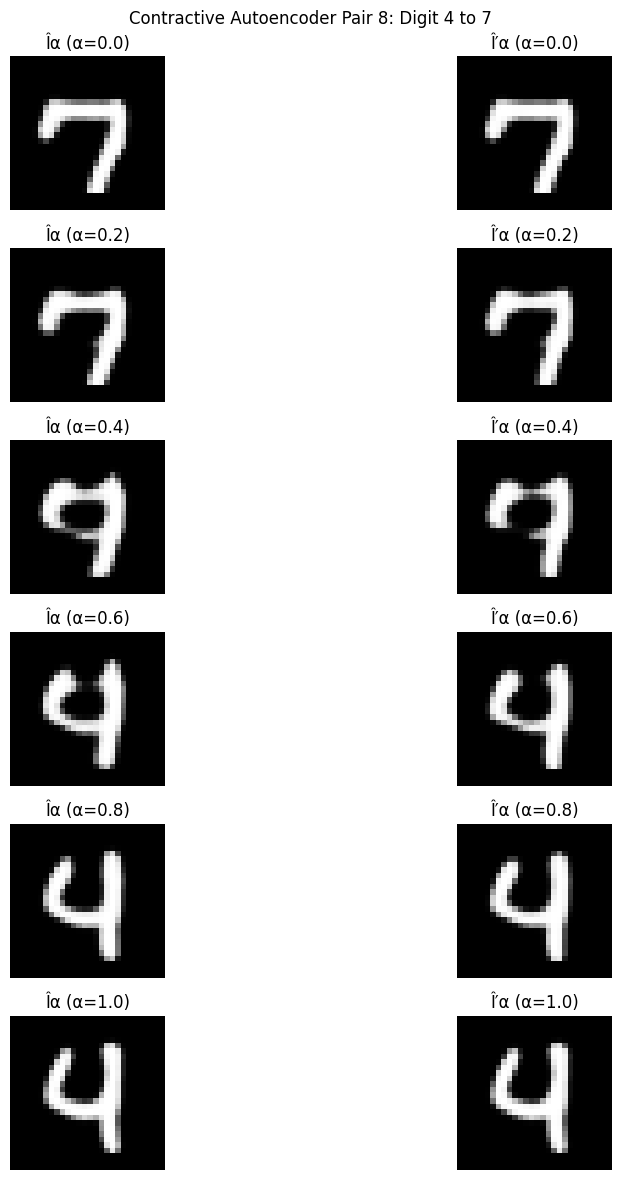

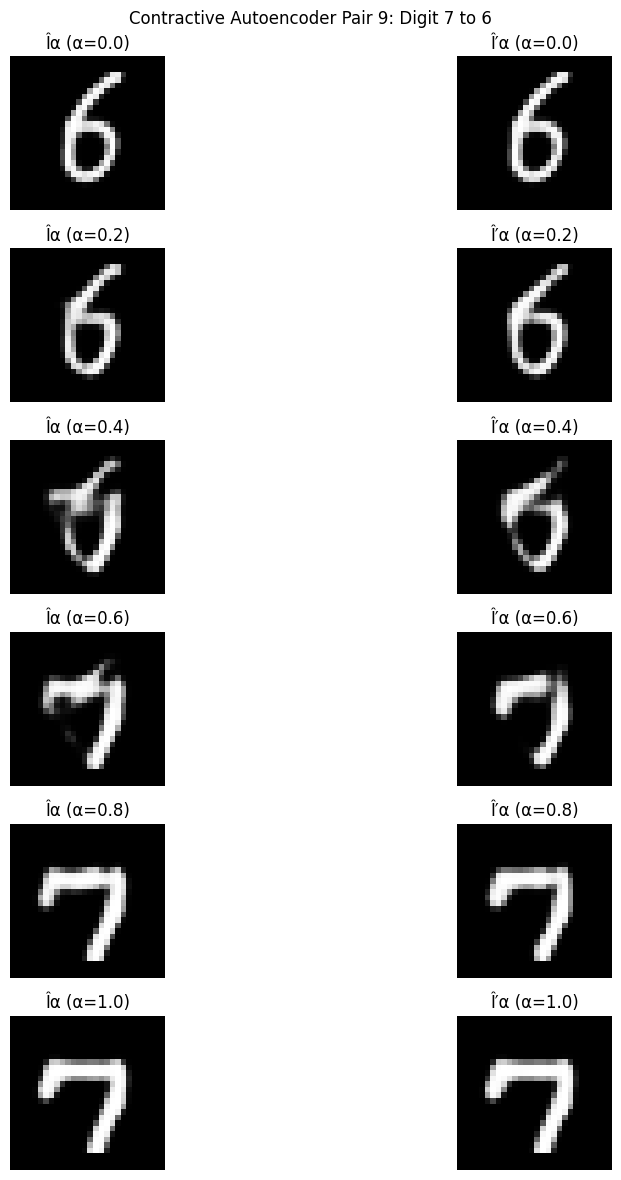

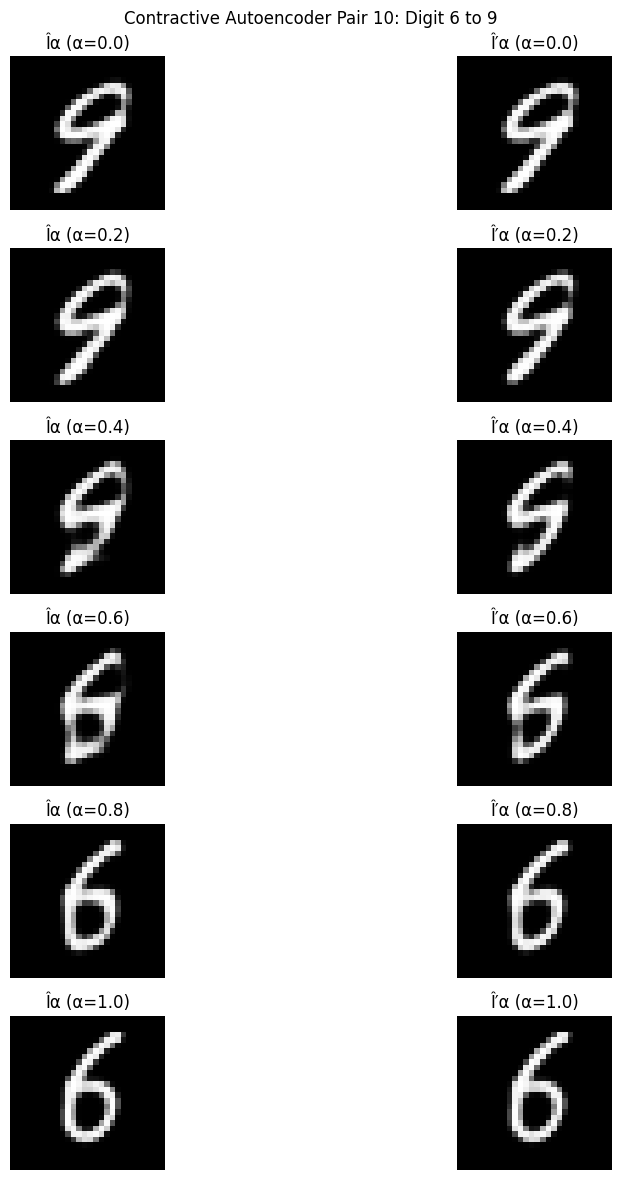

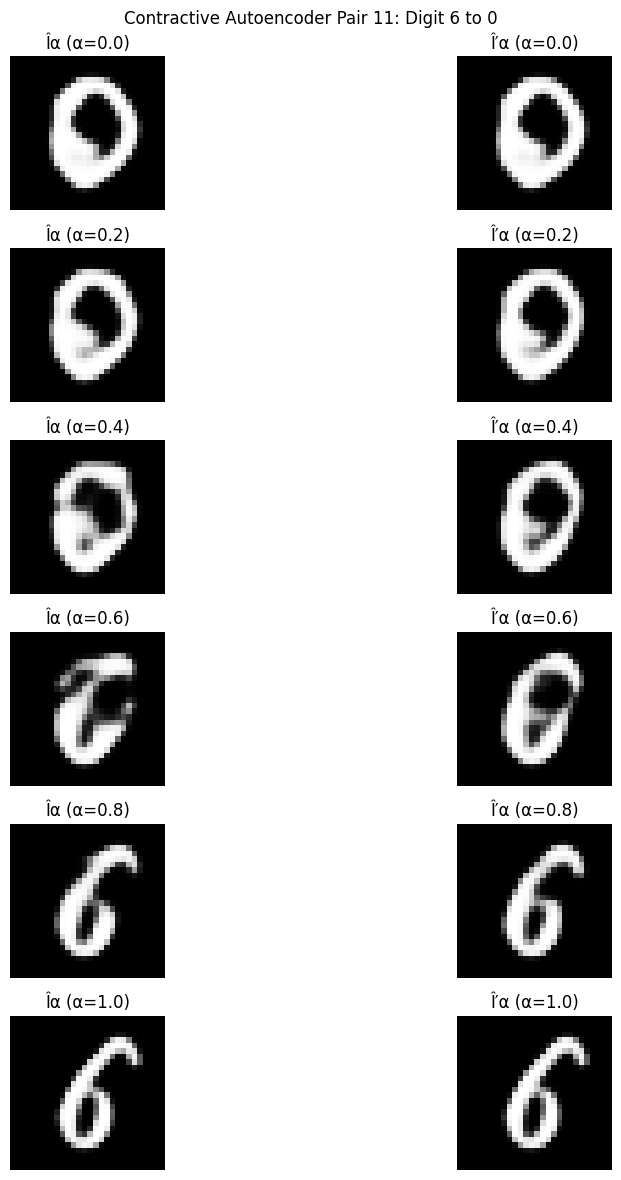

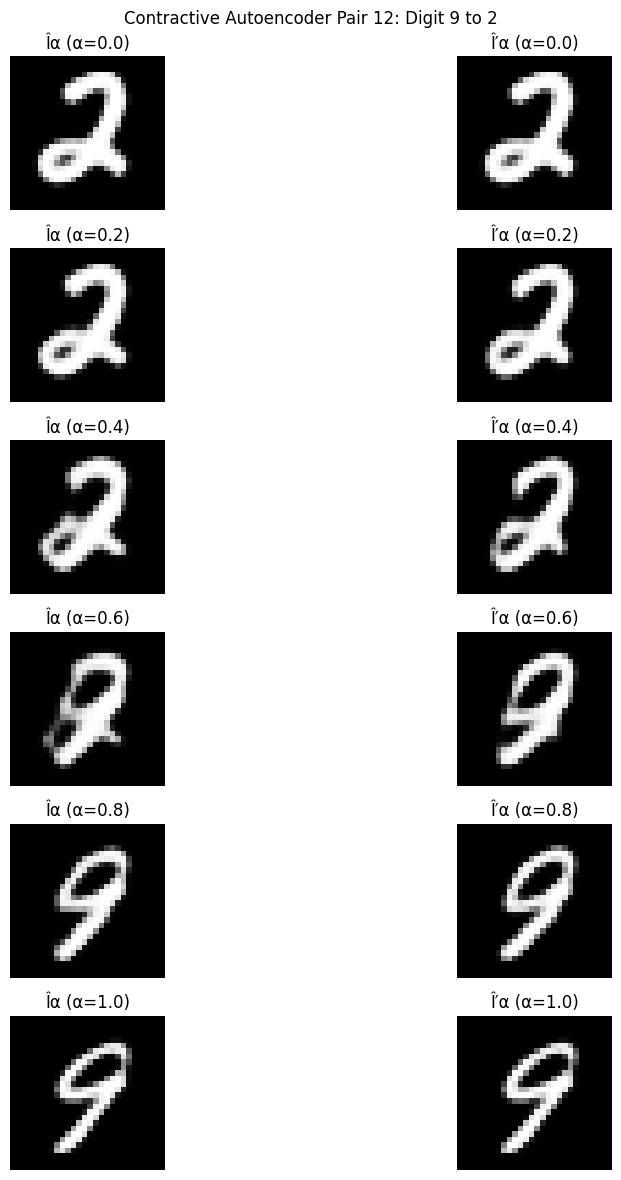

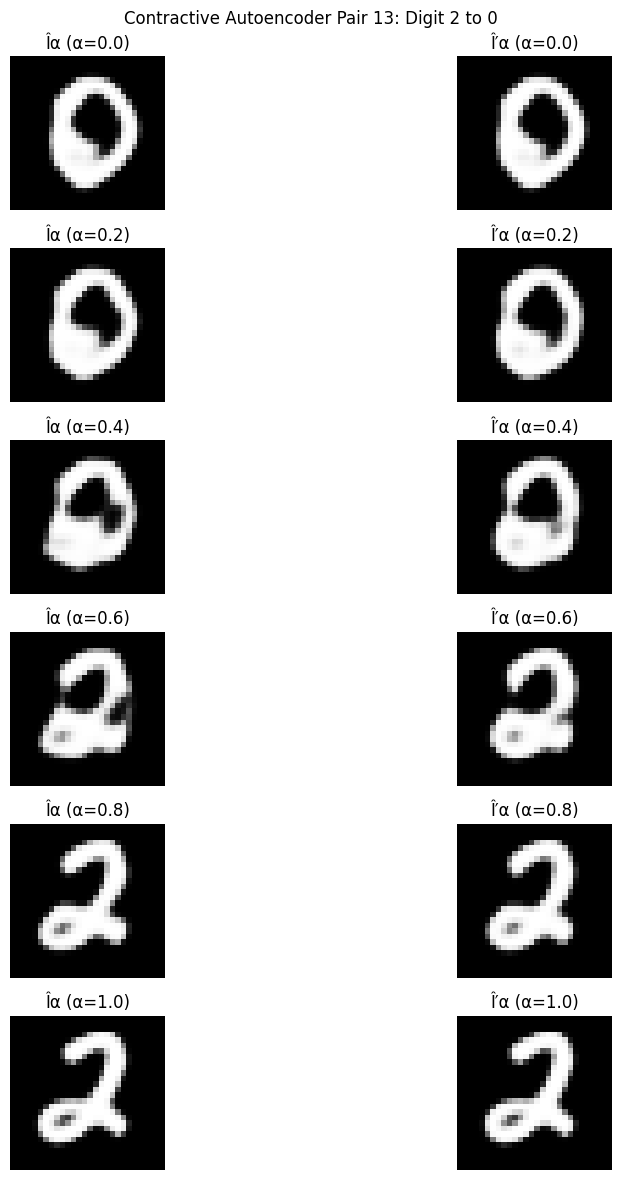

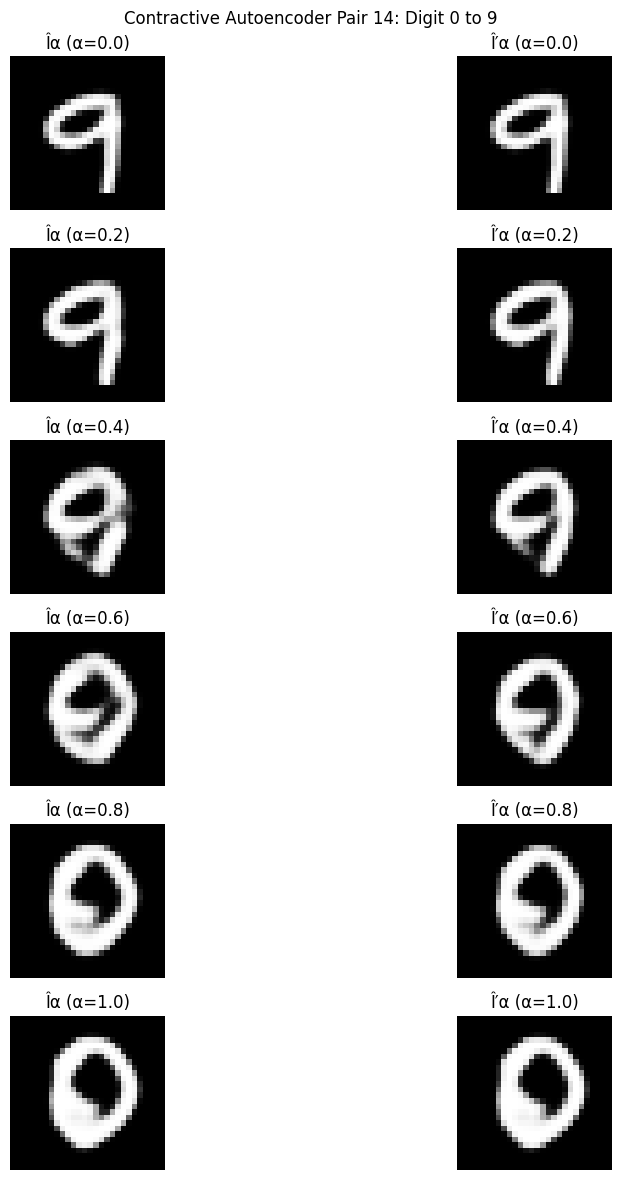

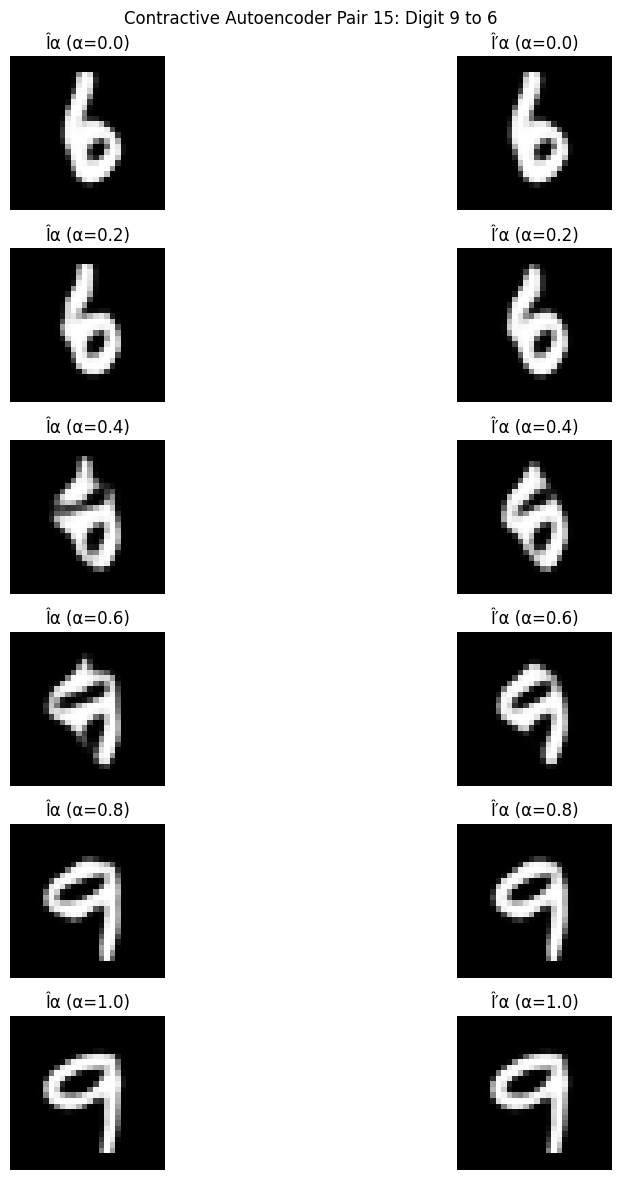

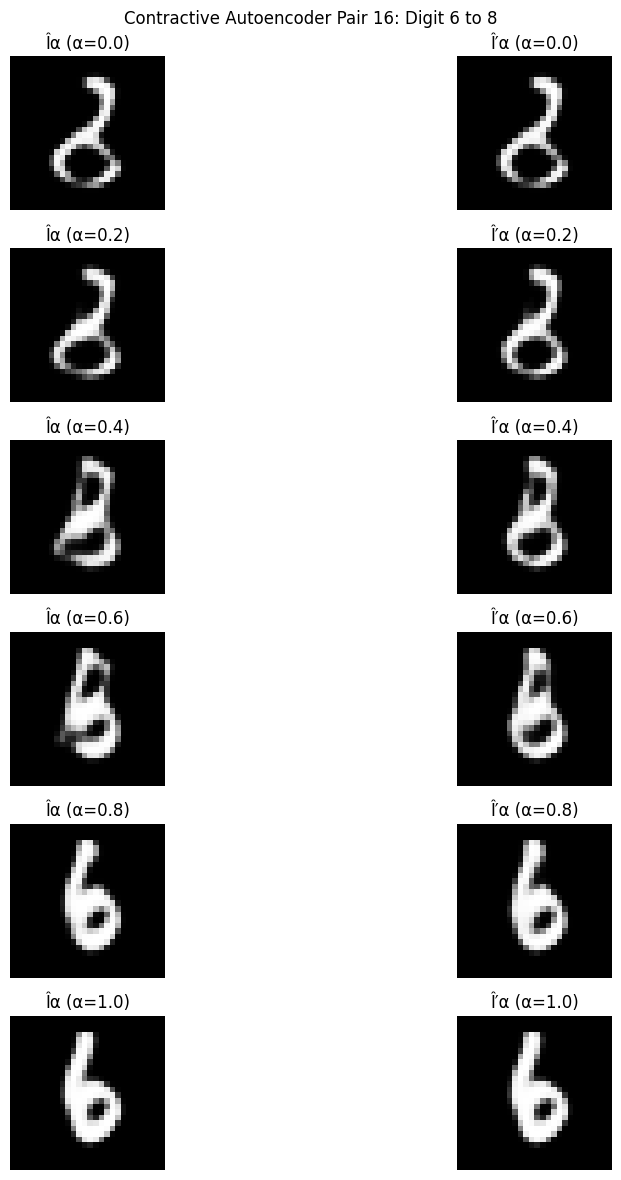

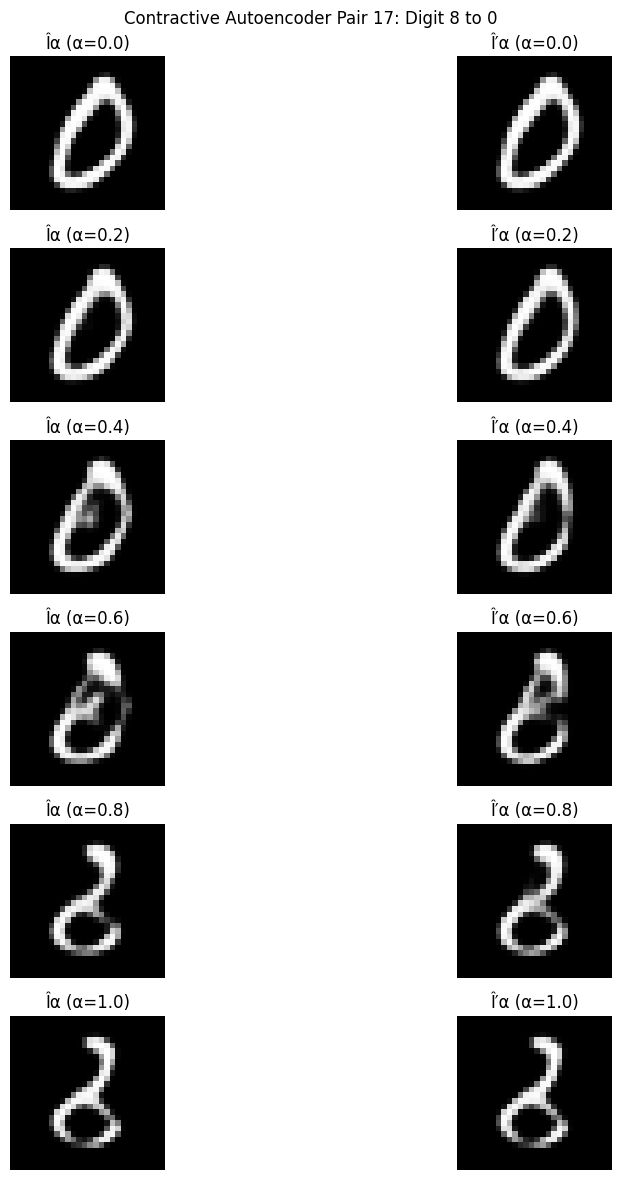

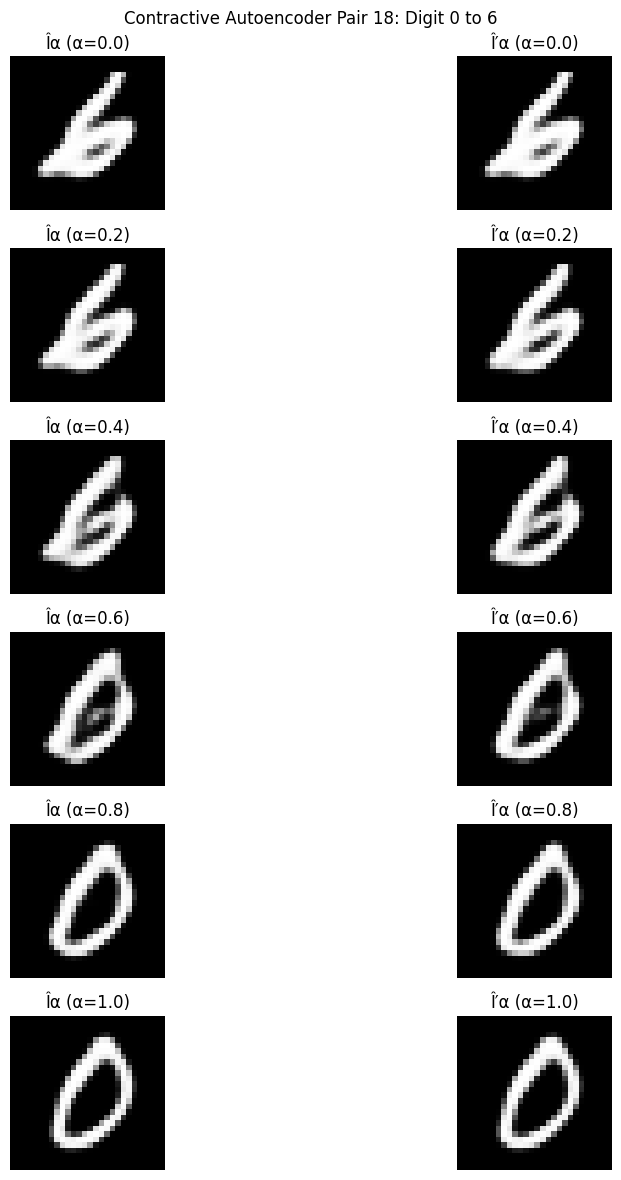

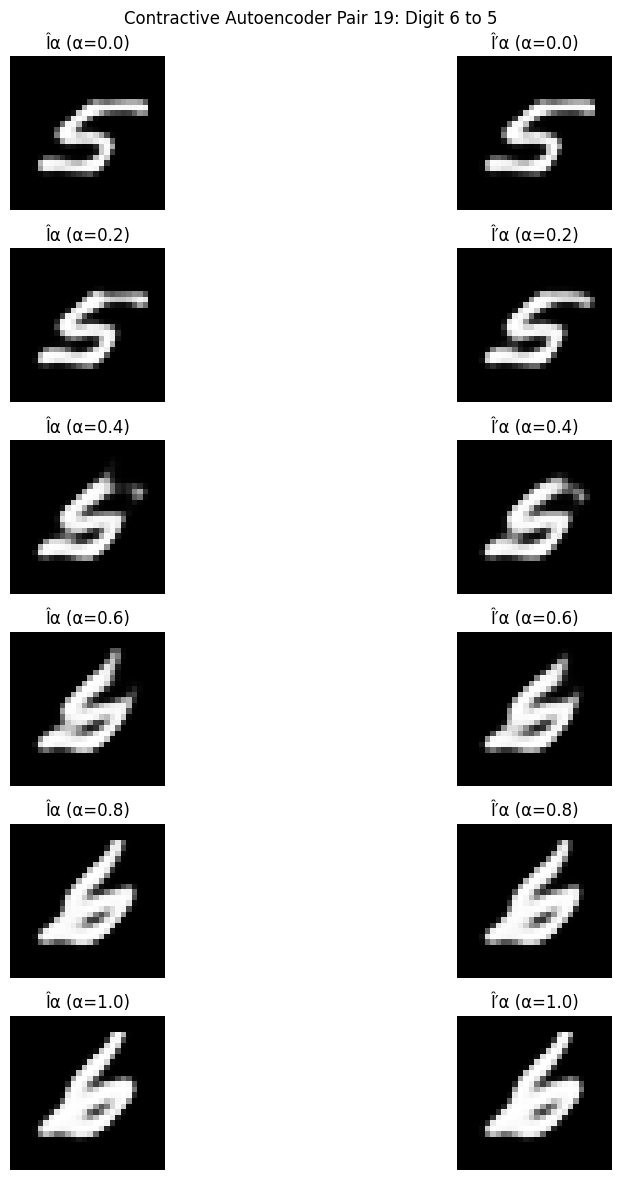

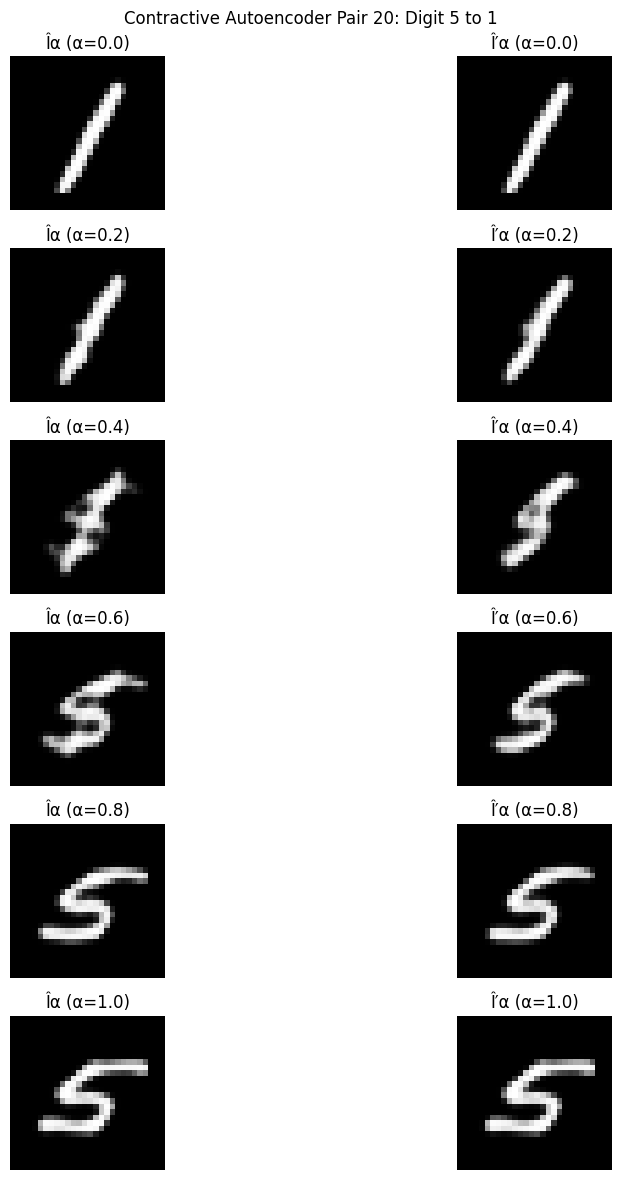


Contractive Autoencoder Metrics:
Alpha | Avg PSNR (dB) | Avg L2 Norm
------|---------------|------------
0.0  | inf      | 0.0000
0.2  | 26.3589      | 23.0538
0.4  | 21.1034      | 37.5187
0.6  | 20.8682      | 38.2965
0.8  | 26.6647      | 23.6083
1.0  | inf      | 0.0000


In [21]:
# Add imports for PSNR calculation
from sklearn.metrics import mean_squared_error
import math

# Modified dataset loading to include labels
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()
x_train = x_train.astype('float32') / 255.0
x_test = x_test.astype('float32') / 255.0
x_train = np.expand_dims(x_train, axis=-1)  # Shape: (60000, 28, 28, 1)
x_test = np.expand_dims(x_test, axis=-1)   # Shape: (10000, 28, 28, 1)
train_dataset = tf.data.Dataset.from_tensor_slices(x_train).cache().shuffle(60000).batch(batch_size).prefetch(tf.data.AUTOTUNE)
test_dataset = tf.data.Dataset.from_tensor_slices((x_test, y_test)).batch(batch_size).prefetch(tf.data.AUTOTUNE)

# Function to compute PSNR
def compute_psnr(img1, img2, max_val=1.0):
    mse = mean_squared_error(img1.flatten(), img2.flatten())
    if mse == 0:
        return float('inf')
    return 20 * math.log10(max_val / math.sqrt(mse))

# Function to select pairs and perform interpolation analysis
def interpolation_analysis(model, dataset, model_name, num_pairs=20, num_images_per_pair=5):
    # Collect images and labels from test set
    all_images, all_labels = [], []
    for images, labels in dataset:
        all_images.append(images.numpy())
        all_labels.append(labels.numpy())
    all_images = np.concatenate(all_images, axis=0)
    all_labels = np.concatenate(all_labels, axis=0)

    # Randomly select pairs from different classes
    np.random.seed(42)  # For reproducibility
    indices = np.arange(len(all_labels))
    np.random.shuffle(indices)
    selected_pairs = []
    used_labels = set()
    i = 0
    while len(selected_pairs) < num_pairs and i < len(indices):
        idx1 = indices[i]
        label1 = all_labels[idx1]
        # Find an index with a different label
        for j in range(i + 1, len(indices)):
            idx2 = indices[j]
            label2 = all_labels[idx2]
            if label1 != label2 and (label1, label2) not in used_labels:
                selected_pairs.append((idx1, idx2))
                used_labels.add((label1, label2))
                break
        i += 1

    # Alpha values for interpolation
    alphas = [0.0, 0.2, 0.4, 0.6, 0.8, 1.0]
    
    # Store metrics
    psnr_values = {alpha: [] for alpha in alphas}
    l2_norms = {alpha: [] for alpha in alphas}

    # Process each pair
    for pair_idx, (idx1, idx2) in enumerate(selected_pairs[:num_pairs]):
        I1 = all_images[idx1:idx1+1]  # Shape: (1, 28, 28, 1)
        I2 = all_images[idx2:idx2+1]
        label1, label2 = all_labels[idx1], all_labels[idx2]

        # Get embeddings h1 and h2
        h1 = model.encoder(I1, training=False).numpy()  # Shape: (1, 64)
        h2 = model.encoder(I2, training=False).numpy()

        # Plot for this pair
        plt.figure(figsize=(12, len(alphas) * 2))
        for i, alpha in enumerate(alphas):
            # Compute interpolated image Iα
            I_alpha = alpha * I1 + (1 - alpha) * I2
            # Compute embedding hα = E(Iα)
            h_alpha = model.encoder(I_alpha, training=False).numpy()
            # Compute approximate embedding h′α = αh1 + (1−α)h2
            h_prime_alpha = alpha * h1 + (1 - alpha) * h2
            # Decode to get Îα and Î′α
            I_hat_alpha = model.decoder(h_alpha, training=False).numpy()
            I_hat_prime_alpha = model.decoder(h_prime_alpha, training=False).numpy()

            # Compute metrics
            psnr = compute_psnr(I_hat_alpha[0], I_hat_prime_alpha[0])
            l2_norm = np.sqrt(np.sum((h_alpha - h_prime_alpha) ** 2))
            psnr_values[alpha].append(psnr)
            l2_norms[alpha].append(l2_norm)

            # Plot Îα and Î′α
            plt.subplot(len(alphas), 2, i * 2 + 1)
            plt.imshow(I_hat_alpha[0].reshape(28, 28), cmap='gray')
            plt.title(f"Îα (α={alpha:.1f})")
            plt.axis('off')
            plt.subplot(len(alphas), 2, i * 2 + 2)
            plt.imshow(I_hat_prime_alpha[0].reshape(28, 28), cmap='gray')
            plt.title(f"Î′α (α={alpha:.1f})")
            plt.axis('off')
        
        plt.suptitle(f"{model_name} Pair {pair_idx+1}: Digit {label1} to {label2}")
        plt.tight_layout()
        plt.show()

    # Report average metrics
    print(f"\n{model_name} Metrics:")
    print("Alpha | Avg PSNR (dB) | Avg L2 Norm")
    print("------|---------------|------------")
    for alpha in alphas:
        avg_psnr = np.mean(psnr_values[alpha])
        avg_l2_norm = np.mean(l2_norms[alpha])
        print(f"{alpha:.1f}  | {avg_psnr:.4f}      | {avg_l2_norm:.4f}")

# After training and other validations, perform interpolation analysis
print("\nInterpolation Analysis for Sparse Autoencoder...")
interpolation_analysis(sparse_ae, test_dataset, "Sparse Autoencoder")

print("\nInterpolation Analysis for Contractive Autoencoder...")
interpolation_analysis(contractive_ae, test_dataset, "Contractive Autoencoder")

In [22]:
# Add imports for classification
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

# Modified dataset loading to ensure labels are included
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()
x_train = x_train.astype('float32') / 255.0
x_test = x_test.astype('float32') / 255.0
x_train = np.expand_dims(x_train, axis=-1)  # Shape: (60000, 28, 28, 1)
x_test = np.expand_dims(x_test, axis=-1)   # Shape: (10000, 28, 28, 1)
train_dataset = tf.data.Dataset.from_tensor_slices(x_train).cache().shuffle(60000).batch(batch_size).prefetch(tf.data.AUTOTUNE)
test_dataset = tf.data.Dataset.from_tensor_slices((x_test, y_test)).batch(batch_size).prefetch(tf.data.AUTOTUNE)

# Function to perform classification and evaluate embeddings
def classify_embeddings(model, train_data, train_labels, test_data, test_labels, model_name):
    # Extract embeddings for training set
    train_embeddings = []
    for batch in tf.data.Dataset.from_tensor_slices(train_data).batch(batch_size):
        z = model.encoder(batch, training=False).numpy()
        train_embeddings.append(z)
    train_embeddings = np.concatenate(train_embeddings, axis=0)

    # Extract embeddings for test set
    test_embeddings = []
    for batch, _ in test_dataset:
        z = model.encoder(batch, training=False).numpy()
        test_embeddings.append(z)
    test_embeddings = np.concatenate(test_embeddings, axis=0)

    # Train logistic regression classifier
    classifier = LogisticRegression(max_iter=1000, random_state=42)
    classifier.fit(train_embeddings, train_labels)

    # Predict on test embeddings
    test_predictions = classifier.predict(test_embeddings)

    # Compute accuracy
    accuracy = accuracy_score(test_labels, test_predictions)
    print(f"{model_name} Classification Accuracy: {accuracy:.4f}")

    return accuracy

# After training, reconstruction, t-SNE, and interpolation analysis
print("\nClassifying Digits using Sparse Autoencoder Embeddings...")
sparse_accuracy = classify_embeddings(sparse_ae, x_train, y_train, x_test, y_test, "Sparse Autoencoder")

print("\nClassifying Digits using Contractive Autoencoder Embeddings...")
contractive_accuracy = classify_embeddings(contractive_ae, x_train, y_train, x_test, y_test, "Contractive Autoencoder")

# Compare and report which is better
print("\nComparison:")
if sparse_accuracy > contractive_accuracy:
    print(f"Sparse Autoencoder is better with accuracy {sparse_accuracy:.4f} vs. Contractive Autoencoder {contractive_accuracy:.4f}")
elif contractive_accuracy > sparse_accuracy:
    print(f"Contractive Autoencoder is better with accuracy {contractive_accuracy:.4f} vs. Sparse Autoencoder {sparse_accuracy:.4f}")
else:
    print(f"Both autoencoders have equal accuracy: {sparse_accuracy:.4f}")


Classifying Digits using Sparse Autoencoder Embeddings...
Sparse Autoencoder Classification Accuracy: 0.9566

Classifying Digits using Contractive Autoencoder Embeddings...
Contractive Autoencoder Classification Accuracy: 0.9848

Comparison:
Contractive Autoencoder is better with accuracy 0.9848 vs. Sparse Autoencoder 0.9566


e:\AI\ai-ml-course\venv\Lib\site-packages\sklearn\linear_model\_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
